# Boosting Tree

In [1]:
%config IPCompleter.greedy=True
import helper ## own utils func
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import ensemble, tree, linear_model
from sklearn.preprocessing import Imputer
from sklearn.feature_selection import SelectKBest
from sklearn.decomposition import PCA
#pd.DataFrame(result_pd_RF).to_csv('resultRF.csv',index = False)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import  MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import os
%matplotlib inline 
import pylab 
import scipy.stats as stats
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.utils import shuffle
plt.style.use('ggplot')
#This line force the graph print out in this jupyter Notebook

c:\programdata\anaconda3\lib\site-packages\IPython\html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)
c:\programdata\anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
testset = pd.read_csv('test.csv')
trainset = pd.read_csv('train.csv')
trainset.isnull().sum()
## Some features have almost all null in every rows, so I will remove null> 1000 for cleaning the features a little bit.
features = trainset.columns.values
remove_features = trainset.columns[trainset.isnull().sum()>1000]
testset = testset.drop(remove_features,1)
testset_id = testset['Id']
testset = testset.drop('Id', 1)
## GarageCars has a higher correlation, so Garage Area and GarageYearBlt will be dropped.
## TotalBsmtSF has a higher correlation with 1stFlrSF, so it will be dropped as well.
trainset = trainset.drop(['1stFlrSF','GarageArea','GarageYrBlt'],1)
testset = testset.drop(['1stFlrSF','GarageArea','GarageYrBlt'],1)

## Drop some columns that only have 1 class for most data
drop_cols = ['Street', 'Utilities', 'Condition2', 'RoofMatl', 'Heating']
trainset = trainset.drop(drop_cols, 1)
testset = testset.drop(drop_cols, 1)
#low_var_cat = [col for col in train.select_dtypes(exclude=['number']) if 1 - sum(train[col] == mode(train[col]))/len(train) < 0.03]
#low_var_cat




trainset['SalePrice'] =np.log(trainset['SalePrice'])
train_labels = trainset['SalePrice']
trainset = trainset.drop('SalePrice',1)

from sklearn.model_selection import train_test_split
testset_index = range(len(trainset),len(trainset) + len(testset))

trainset_index, validset_index = train_test_split(range(len(trainset)),
                                    random_state = 42 , test_size = 0.3)
masterset = pd.concat([trainset,testset], axis = 0)
masterset_backup = masterset
# Getting Dummies from all other categorical vars
for col in masterset.dtypes[masterset.dtypes == 'object'].index:
    for_dummy = masterset.pop(col)
    masterset = pd.concat([masterset, pd.get_dummies(for_dummy, prefix=col)], axis=1)
    train_labels_full = train_labels
train_features_full = masterset.iloc[range(len(trainset))]
train_features = masterset.iloc[trainset_index] 
test_features = masterset.iloc[testset_index]
valid_features = masterset.iloc[validset_index]

## Take a copy of it will be a reference of train_labels
valid_labels = train_labels[validset_index].copy() 
train_labels = train_labels[trainset_index]

col = train_features.columns.values
print(train_features.shape)
print(test_features.shape)

(1022, 260)
(1459, 260)


In [5]:
## Model
GBest = ensemble.GradientBoostingRegressor(
                                           
                                           random_state = 42)
PipeGB = Pipeline([('std', MinMaxScaler()),
                   ('boost', GBest)
                  ])
# estimator parameters
loss = ['huber']

estimators = [1024]
learnrate = [0.01]
subsample = [0.6]
max_depth = [5]
max_features = [0.3]
alpha = [0.9]

param_grid_GB = {'boost__alpha' : alpha,
                 'boost__max_features' : max_features,
                 'boost__loss' : loss,
                 'boost__subsample' :subsample,
                 'boost__n_estimators': estimators,
                 'boost__learning_rate':  learnrate,
                 'boost__max_depth' : max_depth
                }



# set model parameters to grid search object
gridCV_GB = GridSearchCV(estimator = PipeGB, 
                             param_grid  = param_grid_GB,
                            n_jobs = 4,
                             scoring = 'neg_mean_squared_error',
                             cv = 3)

        
# train the model
gridCV_GB.fit(train_features.fillna(-1), train_labels)

print(gridCV_GB.best_params_)


{'boost__subsample': 0.6, 'boost__max_depth': 5, 'boost__n_estimators': 1024, 'boost__max_features': 0.3, 'boost__learning_rate': 0.01, 'boost__loss': 'huber', 'boost__alpha': 0.9}


Cross Val (Train set) [ 0.12380677  0.16769239  0.13971758  0.11937702  0.10208061]
Cross Val (valid set) [ 0.11346481  0.14470848  0.17322613  0.10791356  0.11533036]
Accuracy Val(Train set) 0.983252686578
Accuracy Val (Valid set) 0.910942417631
Root Mean Squarted Log Error (Train set):  0.050950251778
Root Mean Squarted Log Error (Valid set):  0.122915732567


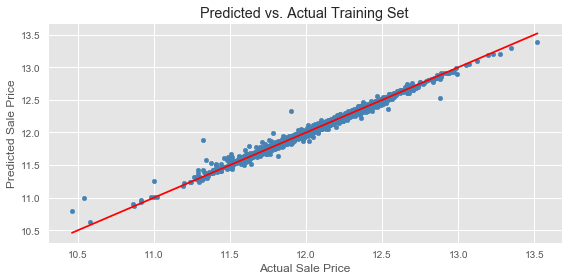

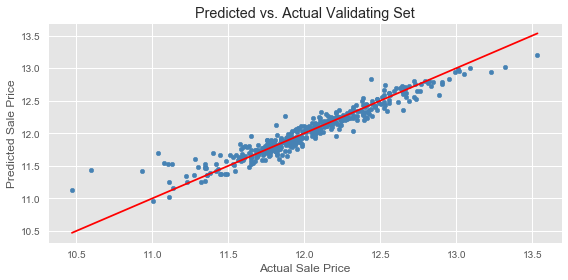

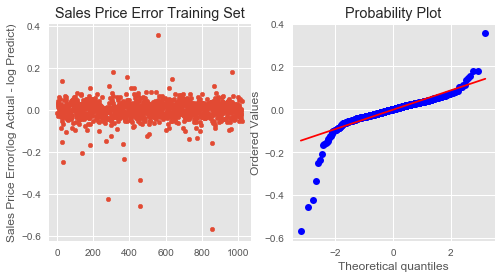

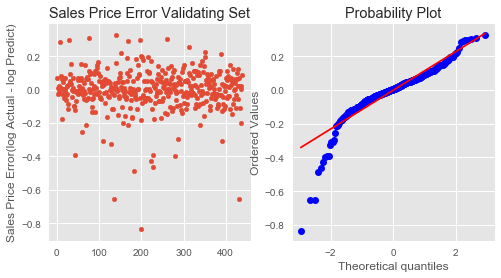

In [6]:
## Running test
helper.summary(gridCV_GB.best_estimator_,train_features.fillna(-1), train_labels, valid_features.fillna(-1), valid_labels)

In [105]:
import importlib
importlib.reload(helper)
import helper

In [151]:
import pickle
# Save the model if rerun above cell for searching hyperparameters
#with open('model_GB.pkl', 'wb') as source:    
#  s = pickle.dump(gridCV_GB.best_estimator_, source)

Cross Val (Train set) [ 0.12167866  0.16548015  0.13630349  0.11817019  0.1029852 ]
Cross Val (valid set) [ 0.11839413  0.14792304  0.17550565  0.10785747  0.11730843]
Accuracy Val(Train set) 0.982577197376
Accuracy Val (Valid set) 0.91106908577
Root Mean Squarted Log Error (Train set):  0.0519676129649
Root Mean Squarted Log Error (Valid set):  0.122828288877


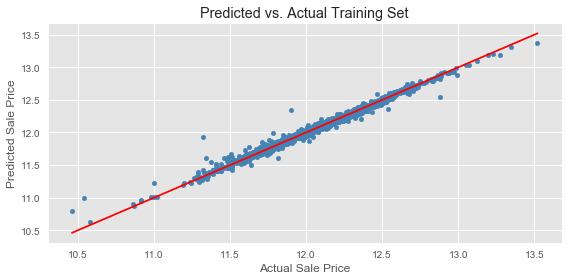

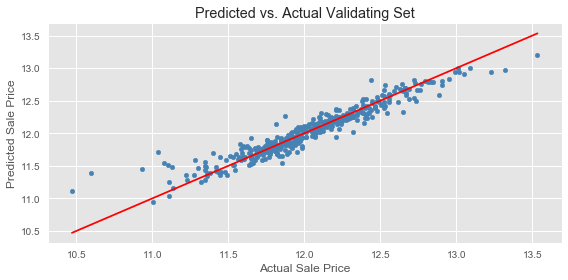

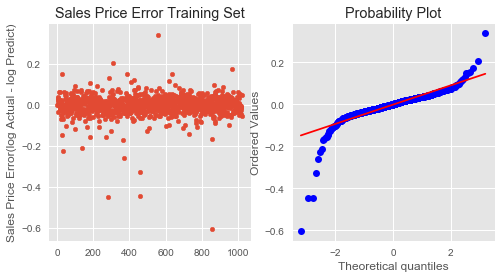

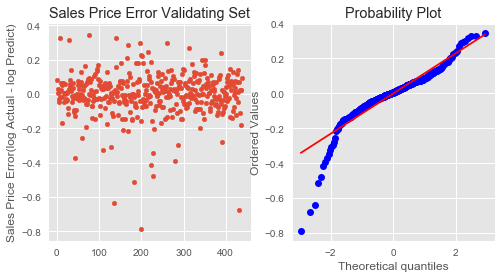

In [152]:
with open('model_GB.pkl','rb') as load:
    model_GB = pickle.load(load)
helper.summary(model_GB,train_features.fillna(-1), train_labels, valid_features.fillna(-1), valid_labels)

In [167]:
model_GB.fit(train_features_full.fillna(-1), train_labels_full)
result_GB = model_GB.predict(test_features.fillna(-1))

In [177]:
result_GB = gridCV_GB.best_estimator_.predict(test_features.fillna(-1))
## Output result, match the require format
result_pd= pd.DataFrame(np.array(list(zip(testset_index,result_GB))),
                        columns=['Id','SalePrice']) ## Id start from 1
result_pd.Id = result_pd.Id.astype('int') + 1 ## Id = index + 1
result_pd['SalePrice'] = result_pd['SalePrice'].apply(lambda x: np.e**(x))
result_pd[0:5]
pd.DataFrame(result_pd).to_csv('resultgb.csv',index = False)

# XGboost

In [109]:
import pandas as pd
import numpy as np
from sklearn.cross_validation import StratifiedKFold, KFold
import xgboost
from sklearn.grid_search import ParameterGrid
from sklearn.metrics import mean_squared_error

CLASS = False  # Whether classification or regression
SCORE_MIN = True  # Optimizing score through minimum
k = 5  # Number of folds
best_score = 10
best_params = None
best_iter = None

train_name = 'train.csv'
test_name = 'test.csv'
#submission_name = '/input/sample_submission.csv'


# Read files
train = pd.DataFrame.from_csv(train_name)
train = train.fillna(-1)
test = pd.DataFrame.from_csv(test_name)
test = test.fillna(-1)
#submission = pd.DataFrame.from_csv(submission_name)
# Extract target
target = train['SalePrice']
del train['SalePrice']

# Label nominal variables to numbers
columns = train.columns.values
nom_numeric_cols = ['MSSubClass']
dummy_train = []
dummy_test = []
for col in columns:
    # Only works for nominal data without a lot of factors
    if train[col].dtype.name == 'object' or col in nom_numeric_cols:
        dummy_train.append(pd.get_dummies(train[col].values.astype(str), col))
        dummy_train[-1].index = train.index
        dummy_test.append(pd.get_dummies(test[col].values.astype(str), col))
        dummy_test[-1].index = test.index
        del train[col]
        del test[col]
train = pd.concat([train] + dummy_train, axis=1)
test = pd.concat([test] + dummy_test, axis=1)

# Use only common columns
columns = []
for col_a in train.columns.values:
    if col_a in test.columns.values:
        columns.append(col_a)
train = train[columns]
test = test[columns]

# CV
train = np.array(train)
target = np.log(np.array(target))  # Changes to Log
test = np.array(test)
print(train.shape, test.shape)

if CLASS:
    kfold = StratifiedKFold(target, k)
else:
    kfold = KFold(train.shape[0], k)

early_stopping = 50

param_grid = [
              {'silent': [1],
               'nthread': [2],
               'eval_metric': ['rmse'],
               'eta': [0.03],
               'objective': ['reg:linear'],
               'max_depth': [5, 7],
               'num_round': [1000],
               'subsample': [0.2, 0.4, 0.6],
               'colsample_bytree': [0.3, 0.5, 0.7],
               }
              ]



c:\programdata\anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


(1460, 299) (1459, 299)


In [ ]:

# Hyperparmeter grid optimization
for params in ParameterGrid(param_grid):
    print(params)
    # Determine best n_rounds
    xgboost_rounds = []
    
    for train_index, test_index in kfold:
        X_train, X_test = train_features, valid_features
        y_train, y_test = train_labels, valid_labels

        xg_train = xgboost.DMatrix(X_train, label=y_train)
        xg_test = xgboost.DMatrix(X_test, label=y_test)

        watchlist = [(xg_train, 'train'), (xg_test, 'test')]

        num_round = params['num_round']
        xgclassifier = xgboost.train(params, xg_train, num_round,
                                     watchlist,
                                     early_stopping_rounds=early_stopping);
        xgboost_rounds.append(xgclassifier.best_iteration)

    num_round = int(np.mean(xgboost_rounds))
    print('The best n_rounds is %d' % num_round)
    # Solve CV
    rmsle_score = []
    for cv_train_index, cv_test_index in kfold:
        X_train, X_test = train[cv_train_index, :], train[cv_test_index, :]
        y_train, y_test = target[cv_train_index], target[cv_test_index]

        # train machine learning
        xg_train = xgboost.DMatrix(X_train, label=y_train)
        xg_test = xgboost.DMatrix(X_test, label=y_test)

        watchlist = [(xg_train, 'train'), (xg_test, 'test')]

        xgclassifier = xgboost.train(params, xg_train, num_round);

        # predict
        predicted_results = xgclassifier.predict(xg_test)
        rmsle_score.append(np.sqrt(mean_squared_error(y_test, predicted_results)))

    if SCORE_MIN:
        if best_score > np.mean(rmsle_score):
            print(np.mean(rmsle_score))
            print('new best')
            best_score = np.mean(rmsle_score)
            best_params = params
            best_iter = num_round
    else:
        if best_score < np.mean(rmsle_score):
            print(np.mean(rmsle_score))
            print('new best')
            best_score = np.mean(rmsle_score)
            best_params = params
            best_iter = num_round

# Solution using best parameters
print('best params: %s' % best_params)
print('best score: %f' % best_score)
xg_train = xgboost.DMatrix(train, label=target)
xg_test = xgboost.DMatrix(test)
watchlist = [(xg_train, 'train')]
num_round = best_iter  # already int
xgclassifier = xgboost.train(best_params, xg_train, num_round, watchlist);


{'colsample_bytree': 0.3, 'silent': 1, 'num_round': 1000, 'objective': 'reg:linear', 'subsample': 0.2, 'eta': 0.03, 'eval_metric': 'rmse', 'max_depth': 5, 'nthread': 2}
[0]	train-rmse:11.1926	test-rmse:11.1772
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 50 rounds.
[1]	train-rmse:10.8592	test-rmse:10.8437
[2]	train-rmse:10.5341	test-rmse:10.5187
[3]	train-rmse:10.2188	test-rmse:10.2034
[4]	train-rmse:9.91407	test-rmse:9.89869
[5]	train-rmse:9.61837	test-rmse:9.603
[6]	train-rmse:9.33149	test-rmse:9.31615
[7]	train-rmse:9.05261	test-rmse:9.0373
[8]	train-rmse:8.78344	test-rmse:8.76815
[9]	train-rmse:8.52215	test-rmse:8.50689
[10]	train-rmse:8.2682	test-rmse:8.25296
[11]	train-rmse:8.02198	test-rmse:8.00677
[12]	train-rmse:7.78428	test-rmse:7.76911
[13]	train-rmse:7.55293	test-rmse:7.53779
[14]	train-rmse:7.32842	test-rmse:7.3133
[15]	train-rmse:7.10893	test-rmse:7.09385
[16]	train-rmse:6.89674	test-rm

[183]	train-rmse:0.126245	test-rmse:0.148232
[184]	train-rmse:0.125189	test-rmse:0.14743
[185]	train-rmse:0.12411	test-rmse:0.146554
[186]	train-rmse:0.123221	test-rmse:0.145842
[187]	train-rmse:0.122387	test-rmse:0.144928
[188]	train-rmse:0.121499	test-rmse:0.144262
[189]	train-rmse:0.120792	test-rmse:0.143833
[190]	train-rmse:0.119883	test-rmse:0.143133
[191]	train-rmse:0.119115	test-rmse:0.142348
[192]	train-rmse:0.118337	test-rmse:0.141617
[193]	train-rmse:0.117633	test-rmse:0.141088
[194]	train-rmse:0.116927	test-rmse:0.140667
[195]	train-rmse:0.116238	test-rmse:0.140313
[196]	train-rmse:0.115853	test-rmse:0.139902
[197]	train-rmse:0.115257	test-rmse:0.139574
[198]	train-rmse:0.114561	test-rmse:0.138915
[199]	train-rmse:0.113969	test-rmse:0.1385
[200]	train-rmse:0.113266	test-rmse:0.138176
[201]	train-rmse:0.112794	test-rmse:0.137748
[202]	train-rmse:0.112358	test-rmse:0.137453
[203]	train-rmse:0.11194	test-rmse:0.137335
[204]	train-rmse:0.111376	test-rmse:0.137028
[205]	train-rms

[367]	train-rmse:0.079932	test-rmse:0.123158
[368]	train-rmse:0.079833	test-rmse:0.123163
[369]	train-rmse:0.079787	test-rmse:0.123149
[370]	train-rmse:0.079635	test-rmse:0.123083
[371]	train-rmse:0.079479	test-rmse:0.122932
[372]	train-rmse:0.07936	test-rmse:0.122898
[373]	train-rmse:0.079222	test-rmse:0.122822
[374]	train-rmse:0.079143	test-rmse:0.122875
[375]	train-rmse:0.079122	test-rmse:0.122968
[376]	train-rmse:0.078975	test-rmse:0.122874
[377]	train-rmse:0.078796	test-rmse:0.122917
[378]	train-rmse:0.078783	test-rmse:0.122901
[379]	train-rmse:0.078649	test-rmse:0.12289
[380]	train-rmse:0.078528	test-rmse:0.122925
[381]	train-rmse:0.078401	test-rmse:0.122969
[382]	train-rmse:0.078293	test-rmse:0.122955
[383]	train-rmse:0.078189	test-rmse:0.122954
[384]	train-rmse:0.078158	test-rmse:0.122867
[385]	train-rmse:0.078066	test-rmse:0.122857
[386]	train-rmse:0.077973	test-rmse:0.122792
[387]	train-rmse:0.077865	test-rmse:0.122824
[388]	train-rmse:0.077725	test-rmse:0.122836
[389]	train-

[40]	train-rmse:3.35285	test-rmse:3.33999
[41]	train-rmse:3.25459	test-rmse:3.2418
[42]	train-rmse:3.15916	test-rmse:3.14684
[43]	train-rmse:3.06812	test-rmse:3.05588
[44]	train-rmse:2.97746	test-rmse:2.9657
[45]	train-rmse:2.88988	test-rmse:2.8782
[46]	train-rmse:2.80409	test-rmse:2.7929
[47]	train-rmse:2.72165	test-rmse:2.71105
[48]	train-rmse:2.64183	test-rmse:2.63171
[49]	train-rmse:2.56486	test-rmse:2.55471
[50]	train-rmse:2.49042	test-rmse:2.48017
[51]	train-rmse:2.41753	test-rmse:2.40799
[52]	train-rmse:2.34653	test-rmse:2.33675
[53]	train-rmse:2.27859	test-rmse:2.26864
[54]	train-rmse:2.21084	test-rmse:2.20136
[55]	train-rmse:2.14558	test-rmse:2.13657
[56]	train-rmse:2.08259	test-rmse:2.07441
[57]	train-rmse:2.02172	test-rmse:2.01394
[58]	train-rmse:1.9629	test-rmse:1.95539
[59]	train-rmse:1.90618	test-rmse:1.89933
[60]	train-rmse:1.85171	test-rmse:1.84534
[61]	train-rmse:1.79728	test-rmse:1.7916
[62]	train-rmse:1.74448	test-rmse:1.7393
[63]	train-rmse:1.69395	test-rmse:1.68894

[227]	train-rmse:0.10289	test-rmse:0.13158
[228]	train-rmse:0.102755	test-rmse:0.131602
[229]	train-rmse:0.102375	test-rmse:0.131608
[230]	train-rmse:0.102171	test-rmse:0.131569
[231]	train-rmse:0.101933	test-rmse:0.131553
[232]	train-rmse:0.101577	test-rmse:0.131251
[233]	train-rmse:0.101316	test-rmse:0.13108
[234]	train-rmse:0.101201	test-rmse:0.130978
[235]	train-rmse:0.10099	test-rmse:0.130968
[236]	train-rmse:0.100672	test-rmse:0.130632
[237]	train-rmse:0.100482	test-rmse:0.130624
[238]	train-rmse:0.100099	test-rmse:0.130505
[239]	train-rmse:0.099701	test-rmse:0.130429
[240]	train-rmse:0.099388	test-rmse:0.130232
[241]	train-rmse:0.099242	test-rmse:0.130015
[242]	train-rmse:0.098964	test-rmse:0.129805
[243]	train-rmse:0.098767	test-rmse:0.129721
[244]	train-rmse:0.098534	test-rmse:0.129573
[245]	train-rmse:0.098325	test-rmse:0.129528
[246]	train-rmse:0.097989	test-rmse:0.129352
[247]	train-rmse:0.097657	test-rmse:0.129228
[248]	train-rmse:0.097292	test-rmse:0.128954
[249]	train-rm

[410]	train-rmse:0.075657	test-rmse:0.122469
[411]	train-rmse:0.075563	test-rmse:0.122418
[412]	train-rmse:0.07551	test-rmse:0.122478
[413]	train-rmse:0.075346	test-rmse:0.122523
[414]	train-rmse:0.075264	test-rmse:0.122446
[415]	train-rmse:0.07515	test-rmse:0.122476
[416]	train-rmse:0.075013	test-rmse:0.122406
[417]	train-rmse:0.07494	test-rmse:0.12239
[418]	train-rmse:0.074897	test-rmse:0.122509
[419]	train-rmse:0.074806	test-rmse:0.122508
[420]	train-rmse:0.074734	test-rmse:0.122486
[421]	train-rmse:0.074632	test-rmse:0.122445
[422]	train-rmse:0.074631	test-rmse:0.122481
[423]	train-rmse:0.074575	test-rmse:0.122486
[424]	train-rmse:0.074457	test-rmse:0.12238
[425]	train-rmse:0.074338	test-rmse:0.122403
[426]	train-rmse:0.074157	test-rmse:0.122332
[427]	train-rmse:0.074024	test-rmse:0.122301
[428]	train-rmse:0.073937	test-rmse:0.122362
[429]	train-rmse:0.073873	test-rmse:0.122345
[430]	train-rmse:0.073805	test-rmse:0.122353
[431]	train-rmse:0.07366	test-rmse:0.122216
[432]	train-rmse

[86]	train-rmse:0.869288	test-rmse:0.868077
[87]	train-rmse:0.845262	test-rmse:0.844104
[88]	train-rmse:0.821685	test-rmse:0.820384
[89]	train-rmse:0.799238	test-rmse:0.798242
[90]	train-rmse:0.777082	test-rmse:0.77646
[91]	train-rmse:0.755683	test-rmse:0.755012
[92]	train-rmse:0.734203	test-rmse:0.733691
[93]	train-rmse:0.71478	test-rmse:0.714488
[94]	train-rmse:0.695066	test-rmse:0.695197
[95]	train-rmse:0.676806	test-rmse:0.677318
[96]	train-rmse:0.658372	test-rmse:0.659195
[97]	train-rmse:0.64008	test-rmse:0.641187
[98]	train-rmse:0.623115	test-rmse:0.624548
[99]	train-rmse:0.606688	test-rmse:0.608208
[100]	train-rmse:0.590598	test-rmse:0.59213
[101]	train-rmse:0.574368	test-rmse:0.575988
[102]	train-rmse:0.5591	test-rmse:0.561193
[103]	train-rmse:0.543957	test-rmse:0.546153
[104]	train-rmse:0.530129	test-rmse:0.532588
[105]	train-rmse:0.515742	test-rmse:0.518138
[106]	train-rmse:0.501579	test-rmse:0.504052
[107]	train-rmse:0.488185	test-rmse:0.490909
[108]	train-rmse:0.475367	test

[270]	train-rmse:0.092978	test-rmse:0.127094
[271]	train-rmse:0.092705	test-rmse:0.126771
[272]	train-rmse:0.092505	test-rmse:0.126696
[273]	train-rmse:0.092241	test-rmse:0.126795
[274]	train-rmse:0.09204	test-rmse:0.126731
[275]	train-rmse:0.091947	test-rmse:0.126804
[276]	train-rmse:0.091828	test-rmse:0.126504
[277]	train-rmse:0.091627	test-rmse:0.126444
[278]	train-rmse:0.091518	test-rmse:0.126336
[279]	train-rmse:0.091414	test-rmse:0.126199
[280]	train-rmse:0.091128	test-rmse:0.126053
[281]	train-rmse:0.090979	test-rmse:0.126024
[282]	train-rmse:0.090891	test-rmse:0.1259
[283]	train-rmse:0.090742	test-rmse:0.125799
[284]	train-rmse:0.090506	test-rmse:0.125621
[285]	train-rmse:0.090365	test-rmse:0.125356
[286]	train-rmse:0.090131	test-rmse:0.125226
[287]	train-rmse:0.090055	test-rmse:0.125058
[288]	train-rmse:0.089886	test-rmse:0.124988
[289]	train-rmse:0.089771	test-rmse:0.124935
[290]	train-rmse:0.089546	test-rmse:0.124896
[291]	train-rmse:0.089379	test-rmse:0.124893
[292]	train-r

[453]	train-rmse:0.071444	test-rmse:0.121683
[454]	train-rmse:0.071417	test-rmse:0.121691
[455]	train-rmse:0.071404	test-rmse:0.121597
[456]	train-rmse:0.071399	test-rmse:0.121437
[457]	train-rmse:0.071327	test-rmse:0.121364
[458]	train-rmse:0.071284	test-rmse:0.121451
[459]	train-rmse:0.071113	test-rmse:0.121488
[460]	train-rmse:0.071038	test-rmse:0.121451
[461]	train-rmse:0.070987	test-rmse:0.121461
[462]	train-rmse:0.070952	test-rmse:0.121571
[463]	train-rmse:0.070838	test-rmse:0.121603
[464]	train-rmse:0.070751	test-rmse:0.121552
[465]	train-rmse:0.070576	test-rmse:0.121684
[466]	train-rmse:0.070473	test-rmse:0.121724
[467]	train-rmse:0.070437	test-rmse:0.121727
[468]	train-rmse:0.070339	test-rmse:0.121771
[469]	train-rmse:0.070276	test-rmse:0.121916
[470]	train-rmse:0.070196	test-rmse:0.121954
[471]	train-rmse:0.070085	test-rmse:0.122104
[472]	train-rmse:0.070025	test-rmse:0.122149
[473]	train-rmse:0.069956	test-rmse:0.122139
[474]	train-rmse:0.069856	test-rmse:0.122135
[475]	trai

[130]	train-rmse:0.27803	test-rmse:0.286122
[131]	train-rmse:0.272078	test-rmse:0.280485
[132]	train-rmse:0.266418	test-rmse:0.27499
[133]	train-rmse:0.260665	test-rmse:0.269627
[134]	train-rmse:0.255655	test-rmse:0.264657
[135]	train-rmse:0.250171	test-rmse:0.259521
[136]	train-rmse:0.244874	test-rmse:0.254647
[137]	train-rmse:0.240001	test-rmse:0.249988
[138]	train-rmse:0.235278	test-rmse:0.245399
[139]	train-rmse:0.230674	test-rmse:0.24101
[140]	train-rmse:0.226215	test-rmse:0.236746
[141]	train-rmse:0.221288	test-rmse:0.232088
[142]	train-rmse:0.217258	test-rmse:0.228386
[143]	train-rmse:0.212734	test-rmse:0.224405
[144]	train-rmse:0.20878	test-rmse:0.220979
[145]	train-rmse:0.205142	test-rmse:0.217486
[146]	train-rmse:0.201217	test-rmse:0.213465
[147]	train-rmse:0.197618	test-rmse:0.210399
[148]	train-rmse:0.194189	test-rmse:0.20723
[149]	train-rmse:0.190939	test-rmse:0.204364
[150]	train-rmse:0.187618	test-rmse:0.201238
[151]	train-rmse:0.184201	test-rmse:0.197976
[152]	train-rms

[314]	train-rmse:0.086408	test-rmse:0.124757
[315]	train-rmse:0.08616	test-rmse:0.124717
[316]	train-rmse:0.086029	test-rmse:0.12447
[317]	train-rmse:0.085925	test-rmse:0.124384
[318]	train-rmse:0.08584	test-rmse:0.124445
[319]	train-rmse:0.085781	test-rmse:0.124603
[320]	train-rmse:0.085671	test-rmse:0.124587
[321]	train-rmse:0.085613	test-rmse:0.124437
[322]	train-rmse:0.085486	test-rmse:0.12444
[323]	train-rmse:0.085328	test-rmse:0.124335
[324]	train-rmse:0.085265	test-rmse:0.124214
[325]	train-rmse:0.085111	test-rmse:0.124192
[326]	train-rmse:0.085031	test-rmse:0.124123
[327]	train-rmse:0.084869	test-rmse:0.124057
[328]	train-rmse:0.084761	test-rmse:0.123981
[329]	train-rmse:0.084684	test-rmse:0.123933
[330]	train-rmse:0.084509	test-rmse:0.124054
[331]	train-rmse:0.084453	test-rmse:0.124022
[332]	train-rmse:0.084305	test-rmse:0.123933
[333]	train-rmse:0.084224	test-rmse:0.123845
[334]	train-rmse:0.084123	test-rmse:0.123899
[335]	train-rmse:0.084013	test-rmse:0.123868
[336]	train-rm

[497]	train-rmse:0.067829	test-rmse:0.122531
[498]	train-rmse:0.067757	test-rmse:0.122603
[499]	train-rmse:0.067725	test-rmse:0.122626
[500]	train-rmse:0.067677	test-rmse:0.122514
[501]	train-rmse:0.067607	test-rmse:0.12259
[502]	train-rmse:0.067538	test-rmse:0.122579
[503]	train-rmse:0.06744	test-rmse:0.122531
[504]	train-rmse:0.067416	test-rmse:0.122567
[505]	train-rmse:0.067349	test-rmse:0.122494
[506]	train-rmse:0.067263	test-rmse:0.122566
[507]	train-rmse:0.06718	test-rmse:0.122494
Stopping. Best iteration:
[457]	train-rmse:0.071327	test-rmse:0.121364

[0]	train-rmse:11.1926	test-rmse:11.1772
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 50 rounds.
[1]	train-rmse:10.8592	test-rmse:10.8437
[2]	train-rmse:10.5341	test-rmse:10.5187
[3]	train-rmse:10.2188	test-rmse:10.2034
[4]	train-rmse:9.91407	test-rmse:9.89869
[5]	train-rmse:9.61837	test-rmse:9.603
[6]	train-rmse:9.33149	test-rmse:9.31615
[7]	trai

[174]	train-rmse:0.136681	test-rmse:0.157164
[175]	train-rmse:0.135355	test-rmse:0.156174
[176]	train-rmse:0.13421	test-rmse:0.155231
[177]	train-rmse:0.133063	test-rmse:0.15412
[178]	train-rmse:0.131836	test-rmse:0.153014
[179]	train-rmse:0.13061	test-rmse:0.151969
[180]	train-rmse:0.129476	test-rmse:0.150961
[181]	train-rmse:0.128399	test-rmse:0.149982
[182]	train-rmse:0.127249	test-rmse:0.149154
[183]	train-rmse:0.126245	test-rmse:0.148232
[184]	train-rmse:0.125189	test-rmse:0.14743
[185]	train-rmse:0.12411	test-rmse:0.146554
[186]	train-rmse:0.123221	test-rmse:0.145842
[187]	train-rmse:0.122387	test-rmse:0.144928
[188]	train-rmse:0.121499	test-rmse:0.144262
[189]	train-rmse:0.120792	test-rmse:0.143833
[190]	train-rmse:0.119883	test-rmse:0.143133
[191]	train-rmse:0.119115	test-rmse:0.142348
[192]	train-rmse:0.118337	test-rmse:0.141617
[193]	train-rmse:0.117633	test-rmse:0.141088
[194]	train-rmse:0.116927	test-rmse:0.140667
[195]	train-rmse:0.116238	test-rmse:0.140313
[196]	train-rms

[358]	train-rmse:0.080933	test-rmse:0.123399
[359]	train-rmse:0.080844	test-rmse:0.123308
[360]	train-rmse:0.080782	test-rmse:0.123276
[361]	train-rmse:0.0807	test-rmse:0.123336
[362]	train-rmse:0.080553	test-rmse:0.123158
[363]	train-rmse:0.080436	test-rmse:0.123095
[364]	train-rmse:0.080308	test-rmse:0.123166
[365]	train-rmse:0.080196	test-rmse:0.123238
[366]	train-rmse:0.080089	test-rmse:0.12328
[367]	train-rmse:0.079932	test-rmse:0.123158
[368]	train-rmse:0.079833	test-rmse:0.123163
[369]	train-rmse:0.079787	test-rmse:0.123149
[370]	train-rmse:0.079635	test-rmse:0.123083
[371]	train-rmse:0.079479	test-rmse:0.122932
[372]	train-rmse:0.07936	test-rmse:0.122898
[373]	train-rmse:0.079222	test-rmse:0.122822
[374]	train-rmse:0.079143	test-rmse:0.122875
[375]	train-rmse:0.079122	test-rmse:0.122968
[376]	train-rmse:0.078975	test-rmse:0.122874
[377]	train-rmse:0.078796	test-rmse:0.122917
[378]	train-rmse:0.078783	test-rmse:0.122901
[379]	train-rmse:0.078649	test-rmse:0.12289
[380]	train-rms

[26]	train-rmse:5.09092	test-rmse:5.07669
[27]	train-rmse:4.93946	test-rmse:4.92527
[28]	train-rmse:4.79256	test-rmse:4.77882
[29]	train-rmse:4.65067	test-rmse:4.63698
[30]	train-rmse:4.51314	test-rmse:4.49991
[31]	train-rmse:4.37889	test-rmse:4.36571
[32]	train-rmse:4.24899	test-rmse:4.23643
[33]	train-rmse:4.12274	test-rmse:4.11026
[34]	train-rmse:4.00062	test-rmse:3.98819
[35]	train-rmse:3.88154	test-rmse:3.86961
[36]	train-rmse:3.76664	test-rmse:3.75553
[37]	train-rmse:3.65495	test-rmse:3.64463
[38]	train-rmse:3.54679	test-rmse:3.53691
[39]	train-rmse:3.44189	test-rmse:3.43252
[40]	train-rmse:3.34028	test-rmse:3.33141
[41]	train-rmse:3.2419	test-rmse:3.23293
[42]	train-rmse:3.14604	test-rmse:3.13756
[43]	train-rmse:3.05369	test-rmse:3.0456
[44]	train-rmse:2.96302	test-rmse:2.95529
[45]	train-rmse:2.87546	test-rmse:2.86808
[46]	train-rmse:2.79035	test-rmse:2.78335
[47]	train-rmse:2.70769	test-rmse:2.70076
[48]	train-rmse:2.62753	test-rmse:2.6209
[49]	train-rmse:2.55002	test-rmse:2.5

[213]	train-rmse:0.09199	test-rmse:0.130879
[214]	train-rmse:0.091661	test-rmse:0.130732
[215]	train-rmse:0.091215	test-rmse:0.130413
[216]	train-rmse:0.090865	test-rmse:0.130163
[217]	train-rmse:0.090593	test-rmse:0.13001
[218]	train-rmse:0.090299	test-rmse:0.129853
[219]	train-rmse:0.090043	test-rmse:0.129691
[220]	train-rmse:0.089638	test-rmse:0.129516
[221]	train-rmse:0.089254	test-rmse:0.129311
[222]	train-rmse:0.088908	test-rmse:0.129145
[223]	train-rmse:0.088387	test-rmse:0.12906
[224]	train-rmse:0.088098	test-rmse:0.129007
[225]	train-rmse:0.08785	test-rmse:0.128958
[226]	train-rmse:0.087545	test-rmse:0.128881
[227]	train-rmse:0.087268	test-rmse:0.128814
[228]	train-rmse:0.086902	test-rmse:0.128701
[229]	train-rmse:0.086567	test-rmse:0.128454
[230]	train-rmse:0.08642	test-rmse:0.12842
[231]	train-rmse:0.086194	test-rmse:0.128399
[232]	train-rmse:0.085848	test-rmse:0.128224
[233]	train-rmse:0.085604	test-rmse:0.128011
[234]	train-rmse:0.085428	test-rmse:0.127874
[235]	train-rmse

[397]	train-rmse:0.060944	test-rmse:0.119985
[398]	train-rmse:0.060853	test-rmse:0.119832
[399]	train-rmse:0.060731	test-rmse:0.119865
[400]	train-rmse:0.060586	test-rmse:0.119846
[401]	train-rmse:0.060496	test-rmse:0.119854
[402]	train-rmse:0.060413	test-rmse:0.119835
[403]	train-rmse:0.06021	test-rmse:0.119787
[404]	train-rmse:0.060151	test-rmse:0.119775
[405]	train-rmse:0.060069	test-rmse:0.1198
[406]	train-rmse:0.060008	test-rmse:0.119813
[407]	train-rmse:0.059915	test-rmse:0.119752
[408]	train-rmse:0.059769	test-rmse:0.119692
[409]	train-rmse:0.059673	test-rmse:0.119647
[410]	train-rmse:0.059561	test-rmse:0.119643
[411]	train-rmse:0.059478	test-rmse:0.11962
[412]	train-rmse:0.059402	test-rmse:0.119602
[413]	train-rmse:0.059313	test-rmse:0.1196
[414]	train-rmse:0.059176	test-rmse:0.119575
[415]	train-rmse:0.059098	test-rmse:0.119576
[416]	train-rmse:0.05899	test-rmse:0.119621
[417]	train-rmse:0.058926	test-rmse:0.119641
[418]	train-rmse:0.058824	test-rmse:0.119677
[419]	train-rmse:

[581]	train-rmse:0.044325	test-rmse:0.118714
[582]	train-rmse:0.044286	test-rmse:0.118682
[583]	train-rmse:0.044219	test-rmse:0.1187
[584]	train-rmse:0.04417	test-rmse:0.118701
[585]	train-rmse:0.044088	test-rmse:0.118701
[586]	train-rmse:0.044016	test-rmse:0.118675
[587]	train-rmse:0.043951	test-rmse:0.1187
[588]	train-rmse:0.043848	test-rmse:0.11866
[589]	train-rmse:0.043795	test-rmse:0.118646
[590]	train-rmse:0.043694	test-rmse:0.11869
[591]	train-rmse:0.043625	test-rmse:0.118708
[592]	train-rmse:0.043563	test-rmse:0.118774
[593]	train-rmse:0.043472	test-rmse:0.11882
[594]	train-rmse:0.04342	test-rmse:0.11884
[595]	train-rmse:0.043383	test-rmse:0.118865
[596]	train-rmse:0.043323	test-rmse:0.118853
[597]	train-rmse:0.043224	test-rmse:0.118887
[598]	train-rmse:0.043103	test-rmse:0.118957
[599]	train-rmse:0.043038	test-rmse:0.118932
[600]	train-rmse:0.042987	test-rmse:0.118914
[601]	train-rmse:0.042923	test-rmse:0.118922
[602]	train-rmse:0.042841	test-rmse:0.11894
[603]	train-rmse:0.04

[126]	train-rmse:0.288074	test-rmse:0.299427
[127]	train-rmse:0.281486	test-rmse:0.293538
[128]	train-rmse:0.275008	test-rmse:0.28747
[129]	train-rmse:0.268497	test-rmse:0.28128
[130]	train-rmse:0.262398	test-rmse:0.275521
[131]	train-rmse:0.256169	test-rmse:0.269732
[132]	train-rmse:0.250365	test-rmse:0.264006
[133]	train-rmse:0.244663	test-rmse:0.258612
[134]	train-rmse:0.239236	test-rmse:0.253477
[135]	train-rmse:0.233689	test-rmse:0.248019
[136]	train-rmse:0.228461	test-rmse:0.243226
[137]	train-rmse:0.223738	test-rmse:0.238773
[138]	train-rmse:0.218991	test-rmse:0.234288
[139]	train-rmse:0.214077	test-rmse:0.229801
[140]	train-rmse:0.209304	test-rmse:0.225452
[141]	train-rmse:0.204888	test-rmse:0.221308
[142]	train-rmse:0.200761	test-rmse:0.217571
[143]	train-rmse:0.196722	test-rmse:0.214094
[144]	train-rmse:0.192894	test-rmse:0.210539
[145]	train-rmse:0.189354	test-rmse:0.207251
[146]	train-rmse:0.185784	test-rmse:0.203967
[147]	train-rmse:0.182073	test-rmse:0.200813
[148]	train-

[309]	train-rmse:0.071675	test-rmse:0.122668
[310]	train-rmse:0.071527	test-rmse:0.122672
[311]	train-rmse:0.071329	test-rmse:0.1226
[312]	train-rmse:0.071278	test-rmse:0.122574
[313]	train-rmse:0.071122	test-rmse:0.122536
[314]	train-rmse:0.07103	test-rmse:0.122534
[315]	train-rmse:0.070897	test-rmse:0.122564
[316]	train-rmse:0.070729	test-rmse:0.122476
[317]	train-rmse:0.070532	test-rmse:0.122391
[318]	train-rmse:0.070405	test-rmse:0.122386
[319]	train-rmse:0.070241	test-rmse:0.12234
[320]	train-rmse:0.070053	test-rmse:0.122278
[321]	train-rmse:0.069928	test-rmse:0.122229
[322]	train-rmse:0.069797	test-rmse:0.122089
[323]	train-rmse:0.06963	test-rmse:0.121995
[324]	train-rmse:0.069545	test-rmse:0.121982
[325]	train-rmse:0.069404	test-rmse:0.12197
[326]	train-rmse:0.069254	test-rmse:0.12191
[327]	train-rmse:0.069052	test-rmse:0.121795
[328]	train-rmse:0.068882	test-rmse:0.121764
[329]	train-rmse:0.068757	test-rmse:0.12171
[330]	train-rmse:0.068651	test-rmse:0.121711
[331]	train-rmse:0

[493]	train-rmse:0.051372	test-rmse:0.118896
[494]	train-rmse:0.05127	test-rmse:0.118845
[495]	train-rmse:0.051197	test-rmse:0.118845
[496]	train-rmse:0.051139	test-rmse:0.118859
[497]	train-rmse:0.051016	test-rmse:0.118847
[498]	train-rmse:0.050876	test-rmse:0.118833
[499]	train-rmse:0.050817	test-rmse:0.11885
[500]	train-rmse:0.050774	test-rmse:0.11882
[501]	train-rmse:0.050687	test-rmse:0.11884
[502]	train-rmse:0.050538	test-rmse:0.118874
[503]	train-rmse:0.050447	test-rmse:0.118891
[504]	train-rmse:0.050385	test-rmse:0.118855
[505]	train-rmse:0.050247	test-rmse:0.118847
[506]	train-rmse:0.050166	test-rmse:0.118921
[507]	train-rmse:0.050095	test-rmse:0.118954
[508]	train-rmse:0.04998	test-rmse:0.119
[509]	train-rmse:0.049926	test-rmse:0.11898
[510]	train-rmse:0.049859	test-rmse:0.118994
[511]	train-rmse:0.049784	test-rmse:0.118981
[512]	train-rmse:0.049681	test-rmse:0.118977
[513]	train-rmse:0.049583	test-rmse:0.118972
[514]	train-rmse:0.049448	test-rmse:0.118985
[515]	train-rmse:0.

[35]	train-rmse:3.88154	test-rmse:3.86961
[36]	train-rmse:3.76664	test-rmse:3.75553
[37]	train-rmse:3.65495	test-rmse:3.64463
[38]	train-rmse:3.54679	test-rmse:3.53691
[39]	train-rmse:3.44189	test-rmse:3.43252
[40]	train-rmse:3.34028	test-rmse:3.33141
[41]	train-rmse:3.2419	test-rmse:3.23293
[42]	train-rmse:3.14604	test-rmse:3.13756
[43]	train-rmse:3.05369	test-rmse:3.0456
[44]	train-rmse:2.96302	test-rmse:2.95529
[45]	train-rmse:2.87546	test-rmse:2.86808
[46]	train-rmse:2.79035	test-rmse:2.78335
[47]	train-rmse:2.70769	test-rmse:2.70076
[48]	train-rmse:2.62753	test-rmse:2.6209
[49]	train-rmse:2.55002	test-rmse:2.54375
[50]	train-rmse:2.47483	test-rmse:2.46848
[51]	train-rmse:2.40184	test-rmse:2.3962
[52]	train-rmse:2.33082	test-rmse:2.32533
[53]	train-rmse:2.26198	test-rmse:2.25668
[54]	train-rmse:2.19512	test-rmse:2.1902
[55]	train-rmse:2.13051	test-rmse:2.12598
[56]	train-rmse:2.06768	test-rmse:2.06379
[57]	train-rmse:2.00718	test-rmse:2.0036
[58]	train-rmse:1.94797	test-rmse:1.9446

[222]	train-rmse:0.088908	test-rmse:0.129145
[223]	train-rmse:0.088387	test-rmse:0.12906
[224]	train-rmse:0.088098	test-rmse:0.129007
[225]	train-rmse:0.08785	test-rmse:0.128958
[226]	train-rmse:0.087545	test-rmse:0.128881
[227]	train-rmse:0.087268	test-rmse:0.128814
[228]	train-rmse:0.086902	test-rmse:0.128701
[229]	train-rmse:0.086567	test-rmse:0.128454
[230]	train-rmse:0.08642	test-rmse:0.12842
[231]	train-rmse:0.086194	test-rmse:0.128399
[232]	train-rmse:0.085848	test-rmse:0.128224
[233]	train-rmse:0.085604	test-rmse:0.128011
[234]	train-rmse:0.085428	test-rmse:0.127874
[235]	train-rmse:0.085212	test-rmse:0.127857
[236]	train-rmse:0.084917	test-rmse:0.127701
[237]	train-rmse:0.084681	test-rmse:0.127561
[238]	train-rmse:0.084356	test-rmse:0.127422
[239]	train-rmse:0.084097	test-rmse:0.127374
[240]	train-rmse:0.083855	test-rmse:0.127294
[241]	train-rmse:0.083617	test-rmse:0.127029
[242]	train-rmse:0.083345	test-rmse:0.126885
[243]	train-rmse:0.083209	test-rmse:0.126815
[244]	train-rm

[406]	train-rmse:0.060008	test-rmse:0.119813
[407]	train-rmse:0.059915	test-rmse:0.119752
[408]	train-rmse:0.059769	test-rmse:0.119692
[409]	train-rmse:0.059673	test-rmse:0.119647
[410]	train-rmse:0.059561	test-rmse:0.119643
[411]	train-rmse:0.059478	test-rmse:0.11962
[412]	train-rmse:0.059402	test-rmse:0.119602
[413]	train-rmse:0.059313	test-rmse:0.1196
[414]	train-rmse:0.059176	test-rmse:0.119575
[415]	train-rmse:0.059098	test-rmse:0.119576
[416]	train-rmse:0.05899	test-rmse:0.119621
[417]	train-rmse:0.058926	test-rmse:0.119641
[418]	train-rmse:0.058824	test-rmse:0.119677
[419]	train-rmse:0.058673	test-rmse:0.119704
[420]	train-rmse:0.058554	test-rmse:0.119638
[421]	train-rmse:0.058465	test-rmse:0.119657
[422]	train-rmse:0.058373	test-rmse:0.119688
[423]	train-rmse:0.058272	test-rmse:0.119656
[424]	train-rmse:0.058179	test-rmse:0.119667
[425]	train-rmse:0.058092	test-rmse:0.11973
[426]	train-rmse:0.058027	test-rmse:0.119761
[427]	train-rmse:0.057986	test-rmse:0.119677
[428]	train-rms

[590]	train-rmse:0.043694	test-rmse:0.11869
[591]	train-rmse:0.043625	test-rmse:0.118708
[592]	train-rmse:0.043563	test-rmse:0.118774
[593]	train-rmse:0.043472	test-rmse:0.11882
[594]	train-rmse:0.04342	test-rmse:0.11884
[595]	train-rmse:0.043383	test-rmse:0.118865
[596]	train-rmse:0.043323	test-rmse:0.118853
[597]	train-rmse:0.043224	test-rmse:0.118887
[598]	train-rmse:0.043103	test-rmse:0.118957
[599]	train-rmse:0.043038	test-rmse:0.118932
[600]	train-rmse:0.042987	test-rmse:0.118914
[601]	train-rmse:0.042923	test-rmse:0.118922
[602]	train-rmse:0.042841	test-rmse:0.11894
[603]	train-rmse:0.042793	test-rmse:0.11894
[604]	train-rmse:0.042734	test-rmse:0.118953
[605]	train-rmse:0.042642	test-rmse:0.118977
[606]	train-rmse:0.042558	test-rmse:0.118962
[607]	train-rmse:0.042461	test-rmse:0.118982
[608]	train-rmse:0.042396	test-rmse:0.11896
[609]	train-rmse:0.04235	test-rmse:0.118966
[610]	train-rmse:0.042317	test-rmse:0.118985
[611]	train-rmse:0.042272	test-rmse:0.118968
[612]	train-rmse:0

[135]	train-rmse:0.233689	test-rmse:0.248019
[136]	train-rmse:0.228461	test-rmse:0.243226
[137]	train-rmse:0.223738	test-rmse:0.238773
[138]	train-rmse:0.218991	test-rmse:0.234288
[139]	train-rmse:0.214077	test-rmse:0.229801
[140]	train-rmse:0.209304	test-rmse:0.225452
[141]	train-rmse:0.204888	test-rmse:0.221308
[142]	train-rmse:0.200761	test-rmse:0.217571
[143]	train-rmse:0.196722	test-rmse:0.214094
[144]	train-rmse:0.192894	test-rmse:0.210539
[145]	train-rmse:0.189354	test-rmse:0.207251
[146]	train-rmse:0.185784	test-rmse:0.203967
[147]	train-rmse:0.182073	test-rmse:0.200813
[148]	train-rmse:0.178613	test-rmse:0.197755
[149]	train-rmse:0.17547	test-rmse:0.195072
[150]	train-rmse:0.172236	test-rmse:0.192193
[151]	train-rmse:0.168899	test-rmse:0.189132
[152]	train-rmse:0.16579	test-rmse:0.186349
[153]	train-rmse:0.162812	test-rmse:0.183733
[154]	train-rmse:0.159809	test-rmse:0.181365
[155]	train-rmse:0.157131	test-rmse:0.179062
[156]	train-rmse:0.154515	test-rmse:0.176872
[157]	train-

[318]	train-rmse:0.070405	test-rmse:0.122386
[319]	train-rmse:0.070241	test-rmse:0.12234
[320]	train-rmse:0.070053	test-rmse:0.122278
[321]	train-rmse:0.069928	test-rmse:0.122229
[322]	train-rmse:0.069797	test-rmse:0.122089
[323]	train-rmse:0.06963	test-rmse:0.121995
[324]	train-rmse:0.069545	test-rmse:0.121982
[325]	train-rmse:0.069404	test-rmse:0.12197
[326]	train-rmse:0.069254	test-rmse:0.12191
[327]	train-rmse:0.069052	test-rmse:0.121795
[328]	train-rmse:0.068882	test-rmse:0.121764
[329]	train-rmse:0.068757	test-rmse:0.12171
[330]	train-rmse:0.068651	test-rmse:0.121711
[331]	train-rmse:0.068486	test-rmse:0.121671
[332]	train-rmse:0.068361	test-rmse:0.121579
[333]	train-rmse:0.068171	test-rmse:0.121625
[334]	train-rmse:0.068025	test-rmse:0.121581
[335]	train-rmse:0.067976	test-rmse:0.121616
[336]	train-rmse:0.067883	test-rmse:0.12159
[337]	train-rmse:0.067812	test-rmse:0.121591
[338]	train-rmse:0.067712	test-rmse:0.121569
[339]	train-rmse:0.067561	test-rmse:0.121613
[340]	train-rmse

[502]	train-rmse:0.050538	test-rmse:0.118874
[503]	train-rmse:0.050447	test-rmse:0.118891
[504]	train-rmse:0.050385	test-rmse:0.118855
[505]	train-rmse:0.050247	test-rmse:0.118847
[506]	train-rmse:0.050166	test-rmse:0.118921
[507]	train-rmse:0.050095	test-rmse:0.118954
[508]	train-rmse:0.04998	test-rmse:0.119
[509]	train-rmse:0.049926	test-rmse:0.11898
[510]	train-rmse:0.049859	test-rmse:0.118994
[511]	train-rmse:0.049784	test-rmse:0.118981
[512]	train-rmse:0.049681	test-rmse:0.118977
[513]	train-rmse:0.049583	test-rmse:0.118972
[514]	train-rmse:0.049448	test-rmse:0.118985
[515]	train-rmse:0.049414	test-rmse:0.118975
[516]	train-rmse:0.049338	test-rmse:0.118953
[517]	train-rmse:0.049293	test-rmse:0.118938
[518]	train-rmse:0.049238	test-rmse:0.118997
[519]	train-rmse:0.049176	test-rmse:0.119012
[520]	train-rmse:0.049079	test-rmse:0.118994
[521]	train-rmse:0.049024	test-rmse:0.118954
[522]	train-rmse:0.048958	test-rmse:0.118969
[523]	train-rmse:0.048859	test-rmse:0.118998
[524]	train-rms

[44]	train-rmse:2.96302	test-rmse:2.95529
[45]	train-rmse:2.87546	test-rmse:2.86808
[46]	train-rmse:2.79035	test-rmse:2.78335
[47]	train-rmse:2.70769	test-rmse:2.70076
[48]	train-rmse:2.62753	test-rmse:2.6209
[49]	train-rmse:2.55002	test-rmse:2.54375
[50]	train-rmse:2.47483	test-rmse:2.46848
[51]	train-rmse:2.40184	test-rmse:2.3962
[52]	train-rmse:2.33082	test-rmse:2.32533
[53]	train-rmse:2.26198	test-rmse:2.25668
[54]	train-rmse:2.19512	test-rmse:2.1902
[55]	train-rmse:2.13051	test-rmse:2.12598
[56]	train-rmse:2.06768	test-rmse:2.06379
[57]	train-rmse:2.00718	test-rmse:2.0036
[58]	train-rmse:1.94797	test-rmse:1.94468
[59]	train-rmse:1.89077	test-rmse:1.88768
[60]	train-rmse:1.83565	test-rmse:1.83292
[61]	train-rmse:1.78172	test-rmse:1.77895
[62]	train-rmse:1.72909	test-rmse:1.72654
[63]	train-rmse:1.6786	test-rmse:1.6762
[64]	train-rmse:1.6295	test-rmse:1.62726
[65]	train-rmse:1.58177	test-rmse:1.57958
[66]	train-rmse:1.53554	test-rmse:1.53315
[67]	train-rmse:1.49065	test-rmse:1.48884

[230]	train-rmse:0.08642	test-rmse:0.12842
[231]	train-rmse:0.086194	test-rmse:0.128399
[232]	train-rmse:0.085848	test-rmse:0.128224
[233]	train-rmse:0.085604	test-rmse:0.128011
[234]	train-rmse:0.085428	test-rmse:0.127874
[235]	train-rmse:0.085212	test-rmse:0.127857
[236]	train-rmse:0.084917	test-rmse:0.127701
[237]	train-rmse:0.084681	test-rmse:0.127561
[238]	train-rmse:0.084356	test-rmse:0.127422
[239]	train-rmse:0.084097	test-rmse:0.127374
[240]	train-rmse:0.083855	test-rmse:0.127294
[241]	train-rmse:0.083617	test-rmse:0.127029
[242]	train-rmse:0.083345	test-rmse:0.126885
[243]	train-rmse:0.083209	test-rmse:0.126815
[244]	train-rmse:0.082998	test-rmse:0.12664
[245]	train-rmse:0.082855	test-rmse:0.126534
[246]	train-rmse:0.082577	test-rmse:0.126366
[247]	train-rmse:0.082274	test-rmse:0.126216
[248]	train-rmse:0.081873	test-rmse:0.126045
[249]	train-rmse:0.081653	test-rmse:0.125929
[250]	train-rmse:0.081456	test-rmse:0.12586
[251]	train-rmse:0.081232	test-rmse:0.125831
[252]	train-rm

[414]	train-rmse:0.059176	test-rmse:0.119575
[415]	train-rmse:0.059098	test-rmse:0.119576
[416]	train-rmse:0.05899	test-rmse:0.119621
[417]	train-rmse:0.058926	test-rmse:0.119641
[418]	train-rmse:0.058824	test-rmse:0.119677
[419]	train-rmse:0.058673	test-rmse:0.119704
[420]	train-rmse:0.058554	test-rmse:0.119638
[421]	train-rmse:0.058465	test-rmse:0.119657
[422]	train-rmse:0.058373	test-rmse:0.119688
[423]	train-rmse:0.058272	test-rmse:0.119656
[424]	train-rmse:0.058179	test-rmse:0.119667
[425]	train-rmse:0.058092	test-rmse:0.11973
[426]	train-rmse:0.058027	test-rmse:0.119761
[427]	train-rmse:0.057986	test-rmse:0.119677
[428]	train-rmse:0.05786	test-rmse:0.119789
[429]	train-rmse:0.057802	test-rmse:0.119802
[430]	train-rmse:0.057669	test-rmse:0.119863
[431]	train-rmse:0.057579	test-rmse:0.11982
[432]	train-rmse:0.057491	test-rmse:0.119817
[433]	train-rmse:0.057393	test-rmse:0.119839
[434]	train-rmse:0.057266	test-rmse:0.119799
[435]	train-rmse:0.05718	test-rmse:0.119733
[436]	train-rms

[598]	train-rmse:0.043103	test-rmse:0.118957
[599]	train-rmse:0.043038	test-rmse:0.118932
[600]	train-rmse:0.042987	test-rmse:0.118914
[601]	train-rmse:0.042923	test-rmse:0.118922
[602]	train-rmse:0.042841	test-rmse:0.11894
[603]	train-rmse:0.042793	test-rmse:0.11894
[604]	train-rmse:0.042734	test-rmse:0.118953
[605]	train-rmse:0.042642	test-rmse:0.118977
[606]	train-rmse:0.042558	test-rmse:0.118962
[607]	train-rmse:0.042461	test-rmse:0.118982
[608]	train-rmse:0.042396	test-rmse:0.11896
[609]	train-rmse:0.04235	test-rmse:0.118966
[610]	train-rmse:0.042317	test-rmse:0.118985
[611]	train-rmse:0.042272	test-rmse:0.118968
[612]	train-rmse:0.042209	test-rmse:0.118972
[613]	train-rmse:0.042137	test-rmse:0.118942
[614]	train-rmse:0.042057	test-rmse:0.118945
[615]	train-rmse:0.041991	test-rmse:0.118903
[616]	train-rmse:0.041955	test-rmse:0.118911
[617]	train-rmse:0.04185	test-rmse:0.118944
[618]	train-rmse:0.041808	test-rmse:0.118942
[619]	train-rmse:0.041762	test-rmse:0.118934
[620]	train-rms

[139]	train-rmse:0.207265	test-rmse:0.224388
[140]	train-rmse:0.202776	test-rmse:0.220505
[141]	train-rmse:0.198377	test-rmse:0.216498
[142]	train-rmse:0.19413	test-rmse:0.212709
[143]	train-rmse:0.189984	test-rmse:0.209226
[144]	train-rmse:0.186063	test-rmse:0.205855
[145]	train-rmse:0.18233	test-rmse:0.202512
[146]	train-rmse:0.178572	test-rmse:0.199386
[147]	train-rmse:0.174978	test-rmse:0.196347
[148]	train-rmse:0.171665	test-rmse:0.193445
[149]	train-rmse:0.168578	test-rmse:0.190819
[150]	train-rmse:0.165469	test-rmse:0.188212
[151]	train-rmse:0.162279	test-rmse:0.185577
[152]	train-rmse:0.159258	test-rmse:0.183083
[153]	train-rmse:0.156395	test-rmse:0.180717
[154]	train-rmse:0.153403	test-rmse:0.178234
[155]	train-rmse:0.150727	test-rmse:0.176049
[156]	train-rmse:0.148145	test-rmse:0.173944
[157]	train-rmse:0.145543	test-rmse:0.171947
[158]	train-rmse:0.14325	test-rmse:0.170268
[159]	train-rmse:0.140832	test-rmse:0.168296
[160]	train-rmse:0.138562	test-rmse:0.166427
[161]	train-r

[322]	train-rmse:0.064128	test-rmse:0.124078
[323]	train-rmse:0.063953	test-rmse:0.124057
[324]	train-rmse:0.063771	test-rmse:0.124052
[325]	train-rmse:0.063664	test-rmse:0.124029
[326]	train-rmse:0.063485	test-rmse:0.124036
[327]	train-rmse:0.063325	test-rmse:0.123992
[328]	train-rmse:0.063181	test-rmse:0.123914
[329]	train-rmse:0.063095	test-rmse:0.123918
[330]	train-rmse:0.062946	test-rmse:0.123919
[331]	train-rmse:0.062768	test-rmse:0.123876
[332]	train-rmse:0.062574	test-rmse:0.123904
[333]	train-rmse:0.062426	test-rmse:0.123886
[334]	train-rmse:0.062273	test-rmse:0.123915
[335]	train-rmse:0.062123	test-rmse:0.12387
[336]	train-rmse:0.061963	test-rmse:0.123851
[337]	train-rmse:0.061877	test-rmse:0.123851
[338]	train-rmse:0.061801	test-rmse:0.123847
[339]	train-rmse:0.061618	test-rmse:0.123829
[340]	train-rmse:0.061461	test-rmse:0.123807
[341]	train-rmse:0.061353	test-rmse:0.123852
[342]	train-rmse:0.061119	test-rmse:0.123729
[343]	train-rmse:0.060995	test-rmse:0.123747
[344]	train

[505]	train-rmse:0.043766	test-rmse:0.122886
[506]	train-rmse:0.043712	test-rmse:0.122937
[507]	train-rmse:0.043592	test-rmse:0.122954
[508]	train-rmse:0.043515	test-rmse:0.122918
[509]	train-rmse:0.043422	test-rmse:0.122917
Stopping. Best iteration:
[459]	train-rmse:0.048111	test-rmse:0.122723

[0]	train-rmse:11.1902	test-rmse:11.1747
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 50 rounds.
[1]	train-rmse:10.8556	test-rmse:10.8402
[2]	train-rmse:10.5303	test-rmse:10.5149
[3]	train-rmse:10.2155	test-rmse:10.2001
[4]	train-rmse:9.9097	test-rmse:9.89431
[5]	train-rmse:9.61335	test-rmse:9.59798
[6]	train-rmse:9.32578	test-rmse:9.31044
[7]	train-rmse:9.04667	test-rmse:9.03136
[8]	train-rmse:8.77628	test-rmse:8.761
[9]	train-rmse:8.51431	test-rmse:8.49905
[10]	train-rmse:8.25969	test-rmse:8.24446
[11]	train-rmse:8.01245	test-rmse:7.99725
[12]	train-rmse:7.77294	test-rmse:7.75776
[13]	train-rmse:7.54074	tes

[180]	train-rmse:0.107183	test-rmse:0.143818
[181]	train-rmse:0.106047	test-rmse:0.143043
[182]	train-rmse:0.104932	test-rmse:0.14221
[183]	train-rmse:0.103929	test-rmse:0.141446
[184]	train-rmse:0.102952	test-rmse:0.140696
[185]	train-rmse:0.102068	test-rmse:0.140109
[186]	train-rmse:0.101271	test-rmse:0.139609
[187]	train-rmse:0.100455	test-rmse:0.139046
[188]	train-rmse:0.099681	test-rmse:0.13855
[189]	train-rmse:0.09893	test-rmse:0.138186
[190]	train-rmse:0.098218	test-rmse:0.137731
[191]	train-rmse:0.097429	test-rmse:0.137186
[192]	train-rmse:0.096717	test-rmse:0.136747
[193]	train-rmse:0.096056	test-rmse:0.136285
[194]	train-rmse:0.095334	test-rmse:0.135948
[195]	train-rmse:0.09481	test-rmse:0.13561
[196]	train-rmse:0.094193	test-rmse:0.135251
[197]	train-rmse:0.093597	test-rmse:0.134834
[198]	train-rmse:0.093068	test-rmse:0.134569
[199]	train-rmse:0.092459	test-rmse:0.134182
[200]	train-rmse:0.091929	test-rmse:0.133881
[201]	train-rmse:0.091384	test-rmse:0.133614
[202]	train-rms

[363]	train-rmse:0.058543	test-rmse:0.123285
[364]	train-rmse:0.058384	test-rmse:0.123271
[365]	train-rmse:0.058273	test-rmse:0.123247
[366]	train-rmse:0.058153	test-rmse:0.123251
[367]	train-rmse:0.058051	test-rmse:0.123294
[368]	train-rmse:0.057931	test-rmse:0.123326
[369]	train-rmse:0.057773	test-rmse:0.123405
[370]	train-rmse:0.05773	test-rmse:0.123424
[371]	train-rmse:0.057625	test-rmse:0.123445
[372]	train-rmse:0.057545	test-rmse:0.123423
[373]	train-rmse:0.057458	test-rmse:0.123389
[374]	train-rmse:0.057333	test-rmse:0.123423
[375]	train-rmse:0.057231	test-rmse:0.123426
[376]	train-rmse:0.057134	test-rmse:0.123391
[377]	train-rmse:0.056964	test-rmse:0.123363
[378]	train-rmse:0.05686	test-rmse:0.123324
[379]	train-rmse:0.056707	test-rmse:0.123331
[380]	train-rmse:0.056605	test-rmse:0.123279
[381]	train-rmse:0.05649	test-rmse:0.123274
[382]	train-rmse:0.05639	test-rmse:0.123255
[383]	train-rmse:0.056318	test-rmse:0.12322
[384]	train-rmse:0.056257	test-rmse:0.123223
[385]	train-rms

[34]	train-rmse:3.99392	test-rmse:3.9829
[35]	train-rmse:3.87482	test-rmse:3.86421
[36]	train-rmse:3.75965	test-rmse:3.74944
[37]	train-rmse:3.64786	test-rmse:3.63837
[38]	train-rmse:3.53927	test-rmse:3.53017
[39]	train-rmse:3.43434	test-rmse:3.42566
[40]	train-rmse:3.3324	test-rmse:3.3241
[41]	train-rmse:3.23358	test-rmse:3.2252
[42]	train-rmse:3.13786	test-rmse:3.1299
[43]	train-rmse:3.04525	test-rmse:3.03765
[44]	train-rmse:2.95456	test-rmse:2.94732
[45]	train-rmse:2.86727	test-rmse:2.86056
[46]	train-rmse:2.78242	test-rmse:2.77628
[47]	train-rmse:2.6999	test-rmse:2.69391
[48]	train-rmse:2.61983	test-rmse:2.61405
[49]	train-rmse:2.5425	test-rmse:2.53731
[50]	train-rmse:2.46733	test-rmse:2.46204
[51]	train-rmse:2.39458	test-rmse:2.38993
[52]	train-rmse:2.32375	test-rmse:2.3195
[53]	train-rmse:2.25518	test-rmse:2.25114
[54]	train-rmse:2.18865	test-rmse:2.18493
[55]	train-rmse:2.12406	test-rmse:2.1202
[56]	train-rmse:2.06115	test-rmse:2.0578
[57]	train-rmse:2.00033	test-rmse:1.99728
[5

[221]	train-rmse:0.083141	test-rmse:0.129293
[222]	train-rmse:0.082827	test-rmse:0.129189
[223]	train-rmse:0.082503	test-rmse:0.129168
[224]	train-rmse:0.082193	test-rmse:0.129108
[225]	train-rmse:0.081938	test-rmse:0.129009
[226]	train-rmse:0.08156	test-rmse:0.128815
[227]	train-rmse:0.081177	test-rmse:0.128799
[228]	train-rmse:0.080863	test-rmse:0.128694
[229]	train-rmse:0.080536	test-rmse:0.128564
[230]	train-rmse:0.080224	test-rmse:0.128364
[231]	train-rmse:0.079976	test-rmse:0.128276
[232]	train-rmse:0.079639	test-rmse:0.128081
[233]	train-rmse:0.079387	test-rmse:0.12797
[234]	train-rmse:0.079176	test-rmse:0.127916
[235]	train-rmse:0.078952	test-rmse:0.127855
[236]	train-rmse:0.078753	test-rmse:0.127746
[237]	train-rmse:0.078474	test-rmse:0.127658
[238]	train-rmse:0.078305	test-rmse:0.127618
[239]	train-rmse:0.078103	test-rmse:0.127621
[240]	train-rmse:0.07791	test-rmse:0.127546
[241]	train-rmse:0.077694	test-rmse:0.127388
[242]	train-rmse:0.077465	test-rmse:0.127278
[243]	train-r

[404]	train-rmse:0.053818	test-rmse:0.123145
[405]	train-rmse:0.053668	test-rmse:0.123124
[406]	train-rmse:0.05356	test-rmse:0.123133
[407]	train-rmse:0.053463	test-rmse:0.12312
[408]	train-rmse:0.05338	test-rmse:0.123153
[409]	train-rmse:0.053305	test-rmse:0.123069
[410]	train-rmse:0.053136	test-rmse:0.12308
[411]	train-rmse:0.053088	test-rmse:0.123056
[412]	train-rmse:0.052977	test-rmse:0.123068
[413]	train-rmse:0.052889	test-rmse:0.123053
[414]	train-rmse:0.052785	test-rmse:0.123007
[415]	train-rmse:0.052733	test-rmse:0.123011
[416]	train-rmse:0.052623	test-rmse:0.12307
[417]	train-rmse:0.052577	test-rmse:0.123068
[418]	train-rmse:0.052486	test-rmse:0.12308
[419]	train-rmse:0.052366	test-rmse:0.123077
[420]	train-rmse:0.052183	test-rmse:0.123021
[421]	train-rmse:0.052124	test-rmse:0.123093
[422]	train-rmse:0.052074	test-rmse:0.123118
[423]	train-rmse:0.05196	test-rmse:0.123071
[424]	train-rmse:0.051865	test-rmse:0.123043
[425]	train-rmse:0.05173	test-rmse:0.123033
[426]	train-rmse:0

[78]	train-rmse:1.073	test-rmse:1.07323
[79]	train-rmse:1.04207	test-rmse:1.04255
[80]	train-rmse:1.01193	test-rmse:1.01263
[81]	train-rmse:0.982874	test-rmse:0.983919
[82]	train-rmse:0.9546	test-rmse:0.955493
[83]	train-rmse:0.926797	test-rmse:0.927572
[84]	train-rmse:0.900168	test-rmse:0.901067
[85]	train-rmse:0.874347	test-rmse:0.875371
[86]	train-rmse:0.849299	test-rmse:0.850323
[87]	train-rmse:0.824911	test-rmse:0.82615
[88]	train-rmse:0.801361	test-rmse:0.80288
[89]	train-rmse:0.778582	test-rmse:0.780292
[90]	train-rmse:0.756134	test-rmse:0.758133
[91]	train-rmse:0.734573	test-rmse:0.736802
[92]	train-rmse:0.713526	test-rmse:0.715823
[93]	train-rmse:0.693529	test-rmse:0.696048
[94]	train-rmse:0.673608	test-rmse:0.676159
[95]	train-rmse:0.654591	test-rmse:0.65769
[96]	train-rmse:0.636225	test-rmse:0.639532
[97]	train-rmse:0.618282	test-rmse:0.621655
[98]	train-rmse:0.600723	test-rmse:0.604346
[99]	train-rmse:0.584116	test-rmse:0.58793
[100]	train-rmse:0.567933	test-rmse:0.57193
[1

[262]	train-rmse:0.073487	test-rmse:0.126317
[263]	train-rmse:0.073312	test-rmse:0.126218
[264]	train-rmse:0.073108	test-rmse:0.126112
[265]	train-rmse:0.072977	test-rmse:0.126036
[266]	train-rmse:0.072785	test-rmse:0.125847
[267]	train-rmse:0.072593	test-rmse:0.125797
[268]	train-rmse:0.072391	test-rmse:0.125753
[269]	train-rmse:0.072184	test-rmse:0.125564
[270]	train-rmse:0.071989	test-rmse:0.125494
[271]	train-rmse:0.071904	test-rmse:0.125457
[272]	train-rmse:0.071797	test-rmse:0.125446
[273]	train-rmse:0.071602	test-rmse:0.125345
[274]	train-rmse:0.071493	test-rmse:0.125317
[275]	train-rmse:0.071341	test-rmse:0.125292
[276]	train-rmse:0.071141	test-rmse:0.125226
[277]	train-rmse:0.07099	test-rmse:0.125237
[278]	train-rmse:0.070868	test-rmse:0.125172
[279]	train-rmse:0.070682	test-rmse:0.125207
[280]	train-rmse:0.070574	test-rmse:0.125161
[281]	train-rmse:0.070338	test-rmse:0.125128
[282]	train-rmse:0.070096	test-rmse:0.125085
[283]	train-rmse:0.069957	test-rmse:0.125059
[284]	train

[445]	train-rmse:0.049615	test-rmse:0.122879
[446]	train-rmse:0.04953	test-rmse:0.122838
[447]	train-rmse:0.049364	test-rmse:0.122863
[448]	train-rmse:0.049254	test-rmse:0.122855
[449]	train-rmse:0.049175	test-rmse:0.122838
[450]	train-rmse:0.049071	test-rmse:0.122862
[451]	train-rmse:0.04897	test-rmse:0.122869
[452]	train-rmse:0.048818	test-rmse:0.12286
[453]	train-rmse:0.048696	test-rmse:0.122854
[454]	train-rmse:0.048626	test-rmse:0.122813
[455]	train-rmse:0.0485	test-rmse:0.12277
[456]	train-rmse:0.048397	test-rmse:0.122755
[457]	train-rmse:0.048267	test-rmse:0.122767
[458]	train-rmse:0.048182	test-rmse:0.122763
[459]	train-rmse:0.048111	test-rmse:0.122723
[460]	train-rmse:0.048005	test-rmse:0.122744
[461]	train-rmse:0.047818	test-rmse:0.12275
[462]	train-rmse:0.047741	test-rmse:0.122752
[463]	train-rmse:0.047624	test-rmse:0.122728
[464]	train-rmse:0.047574	test-rmse:0.122764
[465]	train-rmse:0.047442	test-rmse:0.122803
[466]	train-rmse:0.047335	test-rmse:0.122765
[467]	train-rmse:

[120]	train-rmse:0.328741	test-rmse:0.337764
[121]	train-rmse:0.320267	test-rmse:0.329824
[122]	train-rmse:0.312102	test-rmse:0.322054
[123]	train-rmse:0.304128	test-rmse:0.314469
[124]	train-rmse:0.296633	test-rmse:0.30718
[125]	train-rmse:0.289267	test-rmse:0.300184
[126]	train-rmse:0.282172	test-rmse:0.293419
[127]	train-rmse:0.275132	test-rmse:0.286984
[128]	train-rmse:0.268473	test-rmse:0.280795
[129]	train-rmse:0.26188	test-rmse:0.274779
[130]	train-rmse:0.25564	test-rmse:0.268964
[131]	train-rmse:0.249326	test-rmse:0.263179
[132]	train-rmse:0.24331	test-rmse:0.25748
[133]	train-rmse:0.237848	test-rmse:0.252572
[134]	train-rmse:0.23256	test-rmse:0.247578
[135]	train-rmse:0.227149	test-rmse:0.242451
[136]	train-rmse:0.221885	test-rmse:0.237752
[137]	train-rmse:0.217073	test-rmse:0.23341
[138]	train-rmse:0.21216	test-rmse:0.228847
[139]	train-rmse:0.207265	test-rmse:0.224388
[140]	train-rmse:0.202776	test-rmse:0.220505
[141]	train-rmse:0.198377	test-rmse:0.216498
[142]	train-rmse:0

[303]	train-rmse:0.066704	test-rmse:0.124193
[304]	train-rmse:0.066531	test-rmse:0.124144
[305]	train-rmse:0.066419	test-rmse:0.124183
[306]	train-rmse:0.066362	test-rmse:0.124201
[307]	train-rmse:0.066262	test-rmse:0.124175
[308]	train-rmse:0.066222	test-rmse:0.124159
[309]	train-rmse:0.066032	test-rmse:0.124168
[310]	train-rmse:0.065872	test-rmse:0.124131
[311]	train-rmse:0.065696	test-rmse:0.124122
[312]	train-rmse:0.06555	test-rmse:0.124171
[313]	train-rmse:0.065447	test-rmse:0.124164
[314]	train-rmse:0.06535	test-rmse:0.124159
[315]	train-rmse:0.065195	test-rmse:0.12415
[316]	train-rmse:0.065026	test-rmse:0.124185
[317]	train-rmse:0.064837	test-rmse:0.124128
[318]	train-rmse:0.064703	test-rmse:0.124155
[319]	train-rmse:0.064541	test-rmse:0.124148
[320]	train-rmse:0.064351	test-rmse:0.124121
[321]	train-rmse:0.064267	test-rmse:0.12408
[322]	train-rmse:0.064128	test-rmse:0.124078
[323]	train-rmse:0.063953	test-rmse:0.124057
[324]	train-rmse:0.063771	test-rmse:0.124052
[325]	train-rm

[486]	train-rmse:0.045518	test-rmse:0.122962
[487]	train-rmse:0.045441	test-rmse:0.122953
[488]	train-rmse:0.045298	test-rmse:0.122926
[489]	train-rmse:0.045242	test-rmse:0.122925
[490]	train-rmse:0.045141	test-rmse:0.122911
[491]	train-rmse:0.045009	test-rmse:0.122891
[492]	train-rmse:0.044954	test-rmse:0.122896
[493]	train-rmse:0.044901	test-rmse:0.122899
[494]	train-rmse:0.044786	test-rmse:0.122918
[495]	train-rmse:0.044684	test-rmse:0.122915
[496]	train-rmse:0.044618	test-rmse:0.122921
[497]	train-rmse:0.044457	test-rmse:0.12295
[498]	train-rmse:0.044399	test-rmse:0.122897
[499]	train-rmse:0.044327	test-rmse:0.122876
[500]	train-rmse:0.044298	test-rmse:0.122857
[501]	train-rmse:0.044229	test-rmse:0.122856
[502]	train-rmse:0.044112	test-rmse:0.122889
[503]	train-rmse:0.044016	test-rmse:0.122881
[504]	train-rmse:0.043905	test-rmse:0.122887
[505]	train-rmse:0.043766	test-rmse:0.122886
[506]	train-rmse:0.043712	test-rmse:0.122937
[507]	train-rmse:0.043592	test-rmse:0.122954
[508]	train

[157]	train-rmse:0.164908	test-rmse:0.181797
[158]	train-rmse:0.162552	test-rmse:0.179957
[159]	train-rmse:0.160364	test-rmse:0.178128
[160]	train-rmse:0.157904	test-rmse:0.176108
[161]	train-rmse:0.155763	test-rmse:0.174375
[162]	train-rmse:0.153629	test-rmse:0.172781
[163]	train-rmse:0.151301	test-rmse:0.170909
[164]	train-rmse:0.149384	test-rmse:0.169071
[165]	train-rmse:0.147323	test-rmse:0.167408
[166]	train-rmse:0.145337	test-rmse:0.165581
[167]	train-rmse:0.143781	test-rmse:0.164347
[168]	train-rmse:0.142316	test-rmse:0.162975
[169]	train-rmse:0.140584	test-rmse:0.161476
[170]	train-rmse:0.139269	test-rmse:0.160305
[171]	train-rmse:0.137755	test-rmse:0.158917
[172]	train-rmse:0.136265	test-rmse:0.157853
[173]	train-rmse:0.134551	test-rmse:0.15681
[174]	train-rmse:0.133212	test-rmse:0.155865
[175]	train-rmse:0.131778	test-rmse:0.154983
[176]	train-rmse:0.130619	test-rmse:0.154012
[177]	train-rmse:0.129306	test-rmse:0.152773
[178]	train-rmse:0.128174	test-rmse:0.151591
[179]	train

[340]	train-rmse:0.073964	test-rmse:0.1239
[341]	train-rmse:0.073791	test-rmse:0.124002
[342]	train-rmse:0.07355	test-rmse:0.123854
[343]	train-rmse:0.073488	test-rmse:0.123803
[344]	train-rmse:0.073376	test-rmse:0.123855
[345]	train-rmse:0.073105	test-rmse:0.123779
[346]	train-rmse:0.072962	test-rmse:0.123796
[347]	train-rmse:0.072855	test-rmse:0.123795
[348]	train-rmse:0.07269	test-rmse:0.123839
[349]	train-rmse:0.072545	test-rmse:0.123858
[350]	train-rmse:0.072411	test-rmse:0.12389
[351]	train-rmse:0.072202	test-rmse:0.123815
[352]	train-rmse:0.072049	test-rmse:0.123732
[353]	train-rmse:0.071863	test-rmse:0.123671
[354]	train-rmse:0.071751	test-rmse:0.123691
[355]	train-rmse:0.07152	test-rmse:0.123536
[356]	train-rmse:0.071377	test-rmse:0.123461
[357]	train-rmse:0.071317	test-rmse:0.123365
[358]	train-rmse:0.071245	test-rmse:0.123343
[359]	train-rmse:0.071169	test-rmse:0.123266
[360]	train-rmse:0.071132	test-rmse:0.123289
[361]	train-rmse:0.071026	test-rmse:0.12321
[362]	train-rmse:

[28]	train-rmse:4.80232	test-rmse:4.78776
[29]	train-rmse:4.66082	test-rmse:4.64631
[30]	train-rmse:4.52332	test-rmse:4.50887
[31]	train-rmse:4.38869	test-rmse:4.37429
[32]	train-rmse:4.25833	test-rmse:4.24398
[33]	train-rmse:4.13231	test-rmse:4.11802
[34]	train-rmse:4.01023	test-rmse:3.996
[35]	train-rmse:3.89091	test-rmse:3.87674
[36]	train-rmse:3.77789	test-rmse:3.76378
[37]	train-rmse:3.66642	test-rmse:3.65238
[38]	train-rmse:3.55817	test-rmse:3.54464
[39]	train-rmse:3.45433	test-rmse:3.4414
[40]	train-rmse:3.35285	test-rmse:3.33999
[41]	train-rmse:3.25459	test-rmse:3.2418
[42]	train-rmse:3.15916	test-rmse:3.14684
[43]	train-rmse:3.06812	test-rmse:3.05588
[44]	train-rmse:2.97746	test-rmse:2.9657
[45]	train-rmse:2.88988	test-rmse:2.8782
[46]	train-rmse:2.80409	test-rmse:2.7929
[47]	train-rmse:2.72165	test-rmse:2.71105
[48]	train-rmse:2.64183	test-rmse:2.63171
[49]	train-rmse:2.56486	test-rmse:2.55471
[50]	train-rmse:2.49042	test-rmse:2.48017
[51]	train-rmse:2.41753	test-rmse:2.40799

[215]	train-rmse:0.10124	test-rmse:0.132652
[216]	train-rmse:0.100832	test-rmse:0.132381
[217]	train-rmse:0.100492	test-rmse:0.132174
[218]	train-rmse:0.100313	test-rmse:0.132126
[219]	train-rmse:0.099901	test-rmse:0.132004
[220]	train-rmse:0.099582	test-rmse:0.131906
[221]	train-rmse:0.099201	test-rmse:0.131662
[222]	train-rmse:0.098875	test-rmse:0.131526
[223]	train-rmse:0.098436	test-rmse:0.131258
[224]	train-rmse:0.09815	test-rmse:0.13123
[225]	train-rmse:0.097831	test-rmse:0.131198
[226]	train-rmse:0.097491	test-rmse:0.131062
[227]	train-rmse:0.097162	test-rmse:0.130847
[228]	train-rmse:0.096918	test-rmse:0.130787
[229]	train-rmse:0.096506	test-rmse:0.130662
[230]	train-rmse:0.096218	test-rmse:0.13058
[231]	train-rmse:0.095946	test-rmse:0.130544
[232]	train-rmse:0.095453	test-rmse:0.13035
[233]	train-rmse:0.095187	test-rmse:0.130255
[234]	train-rmse:0.095089	test-rmse:0.130169
[235]	train-rmse:0.094792	test-rmse:0.130012
[236]	train-rmse:0.094378	test-rmse:0.129815
[237]	train-rms

[398]	train-rmse:0.066504	test-rmse:0.123146
[399]	train-rmse:0.066393	test-rmse:0.123117
[400]	train-rmse:0.066283	test-rmse:0.123044
[401]	train-rmse:0.066094	test-rmse:0.12311
[402]	train-rmse:0.065976	test-rmse:0.123078
[403]	train-rmse:0.065827	test-rmse:0.123067
[404]	train-rmse:0.065684	test-rmse:0.123027
[405]	train-rmse:0.065481	test-rmse:0.123119
[406]	train-rmse:0.065416	test-rmse:0.123096
[407]	train-rmse:0.065315	test-rmse:0.123029
[408]	train-rmse:0.06518	test-rmse:0.123073
[409]	train-rmse:0.065075	test-rmse:0.122966
[410]	train-rmse:0.064972	test-rmse:0.12293
[411]	train-rmse:0.064892	test-rmse:0.12291
[412]	train-rmse:0.064763	test-rmse:0.123053
[413]	train-rmse:0.064579	test-rmse:0.123162
[414]	train-rmse:0.064482	test-rmse:0.123162
[415]	train-rmse:0.064396	test-rmse:0.123147
[416]	train-rmse:0.064259	test-rmse:0.123153
[417]	train-rmse:0.064197	test-rmse:0.123128
[418]	train-rmse:0.064045	test-rmse:0.123246
[419]	train-rmse:0.063879	test-rmse:0.123193
[420]	train-rm

[90]	train-rmse:0.777082	test-rmse:0.77646
[91]	train-rmse:0.755683	test-rmse:0.755012
[92]	train-rmse:0.734218	test-rmse:0.733656
[93]	train-rmse:0.714539	test-rmse:0.714159
[94]	train-rmse:0.694781	test-rmse:0.694775
[95]	train-rmse:0.676515	test-rmse:0.676888
[96]	train-rmse:0.658061	test-rmse:0.658505
[97]	train-rmse:0.639766	test-rmse:0.640494
[98]	train-rmse:0.622788	test-rmse:0.623845
[99]	train-rmse:0.606502	test-rmse:0.607523
[100]	train-rmse:0.590481	test-rmse:0.591576
[101]	train-rmse:0.574225	test-rmse:0.575404
[102]	train-rmse:0.558896	test-rmse:0.560561
[103]	train-rmse:0.543742	test-rmse:0.54551
[104]	train-rmse:0.529785	test-rmse:0.532014
[105]	train-rmse:0.515399	test-rmse:0.517569
[106]	train-rmse:0.501147	test-rmse:0.503435
[107]	train-rmse:0.487793	test-rmse:0.490276
[108]	train-rmse:0.474978	test-rmse:0.477865
[109]	train-rmse:0.462859	test-rmse:0.465937
[110]	train-rmse:0.450899	test-rmse:0.454161
[111]	train-rmse:0.439084	test-rmse:0.442296
[112]	train-rmse:0.428

[274]	train-rmse:0.084502	test-rmse:0.125836
[275]	train-rmse:0.084415	test-rmse:0.125897
[276]	train-rmse:0.084219	test-rmse:0.125603
[277]	train-rmse:0.084061	test-rmse:0.125548
[278]	train-rmse:0.083903	test-rmse:0.125542
[279]	train-rmse:0.083733	test-rmse:0.125453
[280]	train-rmse:0.083418	test-rmse:0.125308
[281]	train-rmse:0.08328	test-rmse:0.125334
[282]	train-rmse:0.083187	test-rmse:0.125246
[283]	train-rmse:0.082882	test-rmse:0.125247
[284]	train-rmse:0.082404	test-rmse:0.125014
[285]	train-rmse:0.082222	test-rmse:0.124783
[286]	train-rmse:0.08191	test-rmse:0.12466
[287]	train-rmse:0.081746	test-rmse:0.124533
[288]	train-rmse:0.081596	test-rmse:0.124605
[289]	train-rmse:0.081481	test-rmse:0.124559
[290]	train-rmse:0.081218	test-rmse:0.124579
[291]	train-rmse:0.081006	test-rmse:0.124507
[292]	train-rmse:0.080777	test-rmse:0.124398
[293]	train-rmse:0.080609	test-rmse:0.124467
[294]	train-rmse:0.08049	test-rmse:0.124304
[295]	train-rmse:0.080299	test-rmse:0.124284
[296]	train-rm

[457]	train-rmse:0.060115	test-rmse:0.12286
[458]	train-rmse:0.060099	test-rmse:0.122867
[459]	train-rmse:0.059929	test-rmse:0.122799
[460]	train-rmse:0.059864	test-rmse:0.122836
[461]	train-rmse:0.059799	test-rmse:0.122832
[462]	train-rmse:0.05971	test-rmse:0.122872
[463]	train-rmse:0.05955	test-rmse:0.122852
[464]	train-rmse:0.059478	test-rmse:0.12282
[465]	train-rmse:0.059361	test-rmse:0.122876
[466]	train-rmse:0.059184	test-rmse:0.122898
[467]	train-rmse:0.059079	test-rmse:0.122941
[468]	train-rmse:0.058925	test-rmse:0.123052
[469]	train-rmse:0.058863	test-rmse:0.123171
[470]	train-rmse:0.058776	test-rmse:0.123179
[471]	train-rmse:0.058644	test-rmse:0.123275
[472]	train-rmse:0.058536	test-rmse:0.123242
[473]	train-rmse:0.058392	test-rmse:0.123315
[474]	train-rmse:0.058223	test-rmse:0.123216
[475]	train-rmse:0.058129	test-rmse:0.12318
[476]	train-rmse:0.058033	test-rmse:0.123228
[477]	train-rmse:0.057948	test-rmse:0.123347
[478]	train-rmse:0.057829	test-rmse:0.123289
[479]	train-rms

[149]	train-rmse:0.18901	test-rmse:0.202833
[150]	train-rmse:0.185597	test-rmse:0.199608
[151]	train-rmse:0.182126	test-rmse:0.196474
[152]	train-rmse:0.179096	test-rmse:0.193832
[153]	train-rmse:0.175957	test-rmse:0.191093
[154]	train-rmse:0.17281	test-rmse:0.188426
[155]	train-rmse:0.170283	test-rmse:0.18618
[156]	train-rmse:0.167444	test-rmse:0.183711
[157]	train-rmse:0.164908	test-rmse:0.181797
[158]	train-rmse:0.162552	test-rmse:0.179957
[159]	train-rmse:0.160364	test-rmse:0.178128
[160]	train-rmse:0.157904	test-rmse:0.176108
[161]	train-rmse:0.155763	test-rmse:0.174375
[162]	train-rmse:0.153629	test-rmse:0.172781
[163]	train-rmse:0.151301	test-rmse:0.170909
[164]	train-rmse:0.149384	test-rmse:0.169071
[165]	train-rmse:0.147323	test-rmse:0.167408
[166]	train-rmse:0.145337	test-rmse:0.165581
[167]	train-rmse:0.143781	test-rmse:0.164347
[168]	train-rmse:0.142316	test-rmse:0.162975
[169]	train-rmse:0.140584	test-rmse:0.161476
[170]	train-rmse:0.139269	test-rmse:0.160305
[171]	train-r

[332]	train-rmse:0.074975	test-rmse:0.123818
[333]	train-rmse:0.074843	test-rmse:0.123753
[334]	train-rmse:0.074796	test-rmse:0.123783
[335]	train-rmse:0.074636	test-rmse:0.123804
[336]	train-rmse:0.074479	test-rmse:0.123734
[337]	train-rmse:0.074306	test-rmse:0.123843
[338]	train-rmse:0.074162	test-rmse:0.123858
[339]	train-rmse:0.07406	test-rmse:0.123874
[340]	train-rmse:0.073964	test-rmse:0.1239
[341]	train-rmse:0.073791	test-rmse:0.124002
[342]	train-rmse:0.07355	test-rmse:0.123854
[343]	train-rmse:0.073488	test-rmse:0.123803
[344]	train-rmse:0.073376	test-rmse:0.123855
[345]	train-rmse:0.073105	test-rmse:0.123779
[346]	train-rmse:0.072962	test-rmse:0.123796
[347]	train-rmse:0.072855	test-rmse:0.123795
[348]	train-rmse:0.07269	test-rmse:0.123839
[349]	train-rmse:0.072545	test-rmse:0.123858
[350]	train-rmse:0.072411	test-rmse:0.12389
[351]	train-rmse:0.072202	test-rmse:0.123815
[352]	train-rmse:0.072049	test-rmse:0.123732
[353]	train-rmse:0.071863	test-rmse:0.123671
[354]	train-rmse

[19]	train-rmse:6.29884	test-rmse:6.2839
[20]	train-rmse:6.11234	test-rmse:6.09743
[21]	train-rmse:5.9297	test-rmse:5.91483
[22]	train-rmse:5.75353	test-rmse:5.7387
[23]	train-rmse:5.58333	test-rmse:5.56855
[24]	train-rmse:5.41721	test-rmse:5.40247
[25]	train-rmse:5.25657	test-rmse:5.24188
[26]	train-rmse:5.10011	test-rmse:5.08546
[27]	train-rmse:4.94818	test-rmse:4.93358
[28]	train-rmse:4.80232	test-rmse:4.78776
[29]	train-rmse:4.66082	test-rmse:4.64631
[30]	train-rmse:4.52332	test-rmse:4.50887
[31]	train-rmse:4.38869	test-rmse:4.37429
[32]	train-rmse:4.25833	test-rmse:4.24398
[33]	train-rmse:4.13231	test-rmse:4.11802
[34]	train-rmse:4.01023	test-rmse:3.996
[35]	train-rmse:3.89091	test-rmse:3.87674
[36]	train-rmse:3.77789	test-rmse:3.76378
[37]	train-rmse:3.66642	test-rmse:3.65238
[38]	train-rmse:3.55817	test-rmse:3.54464
[39]	train-rmse:3.45433	test-rmse:3.4414
[40]	train-rmse:3.35285	test-rmse:3.33999
[41]	train-rmse:3.25459	test-rmse:3.2418
[42]	train-rmse:3.15916	test-rmse:3.14684

[207]	train-rmse:0.104919	test-rmse:0.134987
[208]	train-rmse:0.104329	test-rmse:0.134513
[209]	train-rmse:0.103807	test-rmse:0.134315
[210]	train-rmse:0.103451	test-rmse:0.134107
[211]	train-rmse:0.102963	test-rmse:0.133736
[212]	train-rmse:0.102733	test-rmse:0.133608
[213]	train-rmse:0.102118	test-rmse:0.133325
[214]	train-rmse:0.101736	test-rmse:0.133031
[215]	train-rmse:0.10124	test-rmse:0.132652
[216]	train-rmse:0.100832	test-rmse:0.132381
[217]	train-rmse:0.100492	test-rmse:0.132174
[218]	train-rmse:0.100313	test-rmse:0.132126
[219]	train-rmse:0.099901	test-rmse:0.132004
[220]	train-rmse:0.099582	test-rmse:0.131906
[221]	train-rmse:0.099201	test-rmse:0.131662
[222]	train-rmse:0.098875	test-rmse:0.131526
[223]	train-rmse:0.098436	test-rmse:0.131258
[224]	train-rmse:0.09815	test-rmse:0.13123
[225]	train-rmse:0.097831	test-rmse:0.131198
[226]	train-rmse:0.097491	test-rmse:0.131062
[227]	train-rmse:0.097162	test-rmse:0.130847
[228]	train-rmse:0.096918	test-rmse:0.130787
[229]	train-r

[390]	train-rmse:0.067494	test-rmse:0.12325
[391]	train-rmse:0.067367	test-rmse:0.123246
[392]	train-rmse:0.067221	test-rmse:0.123312
[393]	train-rmse:0.06704	test-rmse:0.12317
[394]	train-rmse:0.066963	test-rmse:0.123182
[395]	train-rmse:0.066839	test-rmse:0.123202
[396]	train-rmse:0.066668	test-rmse:0.123149
[397]	train-rmse:0.066591	test-rmse:0.123099
[398]	train-rmse:0.066504	test-rmse:0.123146
[399]	train-rmse:0.066393	test-rmse:0.123117
[400]	train-rmse:0.066283	test-rmse:0.123044
[401]	train-rmse:0.066094	test-rmse:0.12311
[402]	train-rmse:0.065976	test-rmse:0.123078
[403]	train-rmse:0.065827	test-rmse:0.123067
[404]	train-rmse:0.065684	test-rmse:0.123027
[405]	train-rmse:0.065481	test-rmse:0.123119
[406]	train-rmse:0.065416	test-rmse:0.123096
[407]	train-rmse:0.065315	test-rmse:0.123029
[408]	train-rmse:0.06518	test-rmse:0.123073
[409]	train-rmse:0.065075	test-rmse:0.122966
[410]	train-rmse:0.064972	test-rmse:0.12293
[411]	train-rmse:0.064892	test-rmse:0.12291
[412]	train-rmse:

[77]	train-rmse:1.11171	test-rmse:1.11101
[78]	train-rmse:1.07964	test-rmse:1.07912
[79]	train-rmse:1.04869	test-rmse:1.04862
[80]	train-rmse:1.01857	test-rmse:1.01872
[81]	train-rmse:0.989317	test-rmse:0.989622
[82]	train-rmse:0.960751	test-rmse:0.961587
[83]	train-rmse:0.932799	test-rmse:0.933709
[84]	train-rmse:0.906148	test-rmse:0.907427
[85]	train-rmse:0.880417	test-rmse:0.881883
[86]	train-rmse:0.855075	test-rmse:0.856569
[87]	train-rmse:0.831064	test-rmse:0.832969
[88]	train-rmse:0.807427	test-rmse:0.809469
[89]	train-rmse:0.784772	test-rmse:0.786959
[90]	train-rmse:0.762491	test-rmse:0.765145
[91]	train-rmse:0.740951	test-rmse:0.743739
[92]	train-rmse:0.719809	test-rmse:0.722503
[93]	train-rmse:0.699766	test-rmse:0.702464
[94]	train-rmse:0.679989	test-rmse:0.68295
[95]	train-rmse:0.660879	test-rmse:0.664405
[96]	train-rmse:0.642713	test-rmse:0.646398
[97]	train-rmse:0.624827	test-rmse:0.628516
[98]	train-rmse:0.607285	test-rmse:0.611247
[99]	train-rmse:0.590436	test-rmse:0.5948

[261]	train-rmse:0.066061	test-rmse:0.124993
[262]	train-rmse:0.065872	test-rmse:0.12491
[263]	train-rmse:0.065669	test-rmse:0.124765
[264]	train-rmse:0.06538	test-rmse:0.124678
[265]	train-rmse:0.06524	test-rmse:0.124642
[266]	train-rmse:0.065096	test-rmse:0.124599
[267]	train-rmse:0.064853	test-rmse:0.124518
[268]	train-rmse:0.06453	test-rmse:0.124503
[269]	train-rmse:0.064294	test-rmse:0.124479
[270]	train-rmse:0.064087	test-rmse:0.124556
[271]	train-rmse:0.063889	test-rmse:0.124619
[272]	train-rmse:0.063689	test-rmse:0.124571
[273]	train-rmse:0.063435	test-rmse:0.124512
[274]	train-rmse:0.063217	test-rmse:0.124454
[275]	train-rmse:0.063042	test-rmse:0.12444
[276]	train-rmse:0.062751	test-rmse:0.124329
[277]	train-rmse:0.062469	test-rmse:0.124245
[278]	train-rmse:0.062264	test-rmse:0.124175
[279]	train-rmse:0.062071	test-rmse:0.124225
[280]	train-rmse:0.061812	test-rmse:0.124216
[281]	train-rmse:0.061519	test-rmse:0.124123
[282]	train-rmse:0.061273	test-rmse:0.124046
[283]	train-rms

[444]	train-rmse:0.039146	test-rmse:0.121568
[445]	train-rmse:0.039086	test-rmse:0.121534
[446]	train-rmse:0.039005	test-rmse:0.121487
[447]	train-rmse:0.038899	test-rmse:0.121497
[448]	train-rmse:0.038786	test-rmse:0.121494
[449]	train-rmse:0.038661	test-rmse:0.1215
[450]	train-rmse:0.038503	test-rmse:0.121458
[451]	train-rmse:0.038412	test-rmse:0.121471
[452]	train-rmse:0.038273	test-rmse:0.12154
[453]	train-rmse:0.038189	test-rmse:0.121484
[454]	train-rmse:0.038108	test-rmse:0.121523
[455]	train-rmse:0.038001	test-rmse:0.121539
[456]	train-rmse:0.037917	test-rmse:0.121538
[457]	train-rmse:0.037813	test-rmse:0.121558
[458]	train-rmse:0.037777	test-rmse:0.121536
[459]	train-rmse:0.037634	test-rmse:0.121509
[460]	train-rmse:0.037515	test-rmse:0.121499
[461]	train-rmse:0.037434	test-rmse:0.121457
[462]	train-rmse:0.037262	test-rmse:0.121433
[463]	train-rmse:0.037167	test-rmse:0.12138
[464]	train-rmse:0.037097	test-rmse:0.121406
[465]	train-rmse:0.036989	test-rmse:0.121394
[466]	train-rm

[115]	train-rmse:0.381183	test-rmse:0.389107
[116]	train-rmse:0.371014	test-rmse:0.379406
[117]	train-rmse:0.361105	test-rmse:0.369957
[118]	train-rmse:0.351696	test-rmse:0.360726
[119]	train-rmse:0.342977	test-rmse:0.352295
[120]	train-rmse:0.334391	test-rmse:0.343996
[121]	train-rmse:0.325889	test-rmse:0.336009
[122]	train-rmse:0.317548	test-rmse:0.328084
[123]	train-rmse:0.309413	test-rmse:0.320549
[124]	train-rmse:0.301609	test-rmse:0.313318
[125]	train-rmse:0.294315	test-rmse:0.306406
[126]	train-rmse:0.28744	test-rmse:0.300042
[127]	train-rmse:0.280702	test-rmse:0.293874
[128]	train-rmse:0.274223	test-rmse:0.287849
[129]	train-rmse:0.267534	test-rmse:0.281501
[130]	train-rmse:0.261311	test-rmse:0.275756
[131]	train-rmse:0.255017	test-rmse:0.269954
[132]	train-rmse:0.24916	test-rmse:0.264112
[133]	train-rmse:0.243363	test-rmse:0.258702
[134]	train-rmse:0.237945	test-rmse:0.253557
[135]	train-rmse:0.232279	test-rmse:0.248094
[136]	train-rmse:0.227	test-rmse:0.243285
[137]	train-rms

[298]	train-rmse:0.058615	test-rmse:0.123563
[299]	train-rmse:0.058403	test-rmse:0.123469
[300]	train-rmse:0.058306	test-rmse:0.123448
[301]	train-rmse:0.058132	test-rmse:0.123428
[302]	train-rmse:0.058005	test-rmse:0.123357
[303]	train-rmse:0.057825	test-rmse:0.123401
[304]	train-rmse:0.057642	test-rmse:0.123256
[305]	train-rmse:0.057509	test-rmse:0.123332
[306]	train-rmse:0.057337	test-rmse:0.123376
[307]	train-rmse:0.057185	test-rmse:0.123314
[308]	train-rmse:0.057076	test-rmse:0.123299
[309]	train-rmse:0.05687	test-rmse:0.123306
[310]	train-rmse:0.056705	test-rmse:0.123261
[311]	train-rmse:0.056575	test-rmse:0.123221
[312]	train-rmse:0.056446	test-rmse:0.123198
[313]	train-rmse:0.05626	test-rmse:0.123169
[314]	train-rmse:0.056149	test-rmse:0.123165
[315]	train-rmse:0.055953	test-rmse:0.123211
[316]	train-rmse:0.055797	test-rmse:0.123193
[317]	train-rmse:0.05557	test-rmse:0.12312
[318]	train-rmse:0.055437	test-rmse:0.123149
[319]	train-rmse:0.055229	test-rmse:0.123103
[320]	train-rm

[481]	train-rmse:0.035425	test-rmse:0.121415
[482]	train-rmse:0.035271	test-rmse:0.121417
[483]	train-rmse:0.035145	test-rmse:0.121421
[484]	train-rmse:0.035085	test-rmse:0.121453
[485]	train-rmse:0.034999	test-rmse:0.1215
[486]	train-rmse:0.034919	test-rmse:0.12154
[487]	train-rmse:0.034819	test-rmse:0.121557
[488]	train-rmse:0.034751	test-rmse:0.12157
[489]	train-rmse:0.034665	test-rmse:0.121579
[490]	train-rmse:0.034604	test-rmse:0.121563
[491]	train-rmse:0.034509	test-rmse:0.121583
[492]	train-rmse:0.034464	test-rmse:0.121568
[493]	train-rmse:0.034366	test-rmse:0.121597
[494]	train-rmse:0.034295	test-rmse:0.121565
[495]	train-rmse:0.034178	test-rmse:0.121547
[496]	train-rmse:0.034108	test-rmse:0.121599
[497]	train-rmse:0.03399	test-rmse:0.121611
[498]	train-rmse:0.033864	test-rmse:0.121661
[499]	train-rmse:0.033799	test-rmse:0.121666
[500]	train-rmse:0.033766	test-rmse:0.121669
[501]	train-rmse:0.033685	test-rmse:0.12167
[502]	train-rmse:0.033542	test-rmse:0.121733
[503]	train-rmse

[152]	train-rmse:0.162614	test-rmse:0.185898
[153]	train-rmse:0.159463	test-rmse:0.183178
[154]	train-rmse:0.156207	test-rmse:0.180696
[155]	train-rmse:0.153401	test-rmse:0.178317
[156]	train-rmse:0.150666	test-rmse:0.176246
[157]	train-rmse:0.148041	test-rmse:0.174319
[158]	train-rmse:0.145623	test-rmse:0.172648
[159]	train-rmse:0.143193	test-rmse:0.170751
[160]	train-rmse:0.140771	test-rmse:0.168836
[161]	train-rmse:0.138723	test-rmse:0.167226
[162]	train-rmse:0.136509	test-rmse:0.165559
[163]	train-rmse:0.134322	test-rmse:0.164051
[164]	train-rmse:0.132395	test-rmse:0.162691
[165]	train-rmse:0.130249	test-rmse:0.161057
[166]	train-rmse:0.128262	test-rmse:0.159452
[167]	train-rmse:0.126363	test-rmse:0.158034
[168]	train-rmse:0.124517	test-rmse:0.156819
[169]	train-rmse:0.122641	test-rmse:0.15553
[170]	train-rmse:0.121001	test-rmse:0.154348
[171]	train-rmse:0.119481	test-rmse:0.15306
[172]	train-rmse:0.117884	test-rmse:0.152075
[173]	train-rmse:0.11646	test-rmse:0.151179
[174]	train-r

[335]	train-rmse:0.052544	test-rmse:0.122511
[336]	train-rmse:0.052405	test-rmse:0.122484
[337]	train-rmse:0.052277	test-rmse:0.122531
[338]	train-rmse:0.052168	test-rmse:0.122493
[339]	train-rmse:0.052006	test-rmse:0.122555
[340]	train-rmse:0.051823	test-rmse:0.122558
[341]	train-rmse:0.051691	test-rmse:0.122584
[342]	train-rmse:0.051497	test-rmse:0.122606
[343]	train-rmse:0.051257	test-rmse:0.122512
[344]	train-rmse:0.051167	test-rmse:0.122517
[345]	train-rmse:0.05104	test-rmse:0.12249
[346]	train-rmse:0.05084	test-rmse:0.122412
[347]	train-rmse:0.050682	test-rmse:0.122434
[348]	train-rmse:0.050486	test-rmse:0.122431
[349]	train-rmse:0.050357	test-rmse:0.122481
[350]	train-rmse:0.050243	test-rmse:0.122446
[351]	train-rmse:0.050042	test-rmse:0.12239
[352]	train-rmse:0.049954	test-rmse:0.122351
[353]	train-rmse:0.049805	test-rmse:0.122297
[354]	train-rmse:0.049705	test-rmse:0.122199
[355]	train-rmse:0.049538	test-rmse:0.122178
[356]	train-rmse:0.0494	test-rmse:0.122155
[357]	train-rmse

Will train until test-rmse hasn't improved in 50 rounds.
[1]	train-rmse:10.8566	test-rmse:10.8411
[2]	train-rmse:10.531	test-rmse:10.5156
[3]	train-rmse:10.2161	test-rmse:10.2007
[4]	train-rmse:9.91099	test-rmse:9.89561
[5]	train-rmse:9.61475	test-rmse:9.59939
[6]	train-rmse:9.32709	test-rmse:9.31175
[7]	train-rmse:9.0482	test-rmse:9.03289
[8]	train-rmse:8.77772	test-rmse:8.76243
[9]	train-rmse:8.51553	test-rmse:8.50027
[10]	train-rmse:8.26119	test-rmse:8.24595
[11]	train-rmse:8.01454	test-rmse:7.99934
[12]	train-rmse:7.77564	test-rmse:7.76047
[13]	train-rmse:7.54434	test-rmse:7.52919
[14]	train-rmse:7.31837	test-rmse:7.30326
[15]	train-rmse:7.09922	test-rmse:7.08413
[16]	train-rmse:6.88734	test-rmse:6.87229
[17]	train-rmse:6.68171	test-rmse:6.6667
[18]	train-rmse:6.48243	test-rmse:6.46745
[19]	train-rmse:6.28925	test-rmse:6.27431
[20]	train-rmse:6.10205	test-rmse:6.08715
[21]	train-rmse:5.9203	test-rmse:5.90544
[22]	train-rmse:5.74336	test-rmse:5.72854
[23]	train-rmse:5.57276	test-rms

[189]	train-rmse:0.097436	test-rmse:0.138862
[190]	train-rmse:0.09648	test-rmse:0.138341
[191]	train-rmse:0.095621	test-rmse:0.137727
[192]	train-rmse:0.094816	test-rmse:0.137394
[193]	train-rmse:0.094103	test-rmse:0.136827
[194]	train-rmse:0.093138	test-rmse:0.136335
[195]	train-rmse:0.092503	test-rmse:0.13591
[196]	train-rmse:0.091794	test-rmse:0.135417
[197]	train-rmse:0.091051	test-rmse:0.135035
[198]	train-rmse:0.090331	test-rmse:0.134544
[199]	train-rmse:0.089458	test-rmse:0.133954
[200]	train-rmse:0.08884	test-rmse:0.13371
[201]	train-rmse:0.08807	test-rmse:0.133309
[202]	train-rmse:0.087434	test-rmse:0.133157
[203]	train-rmse:0.086576	test-rmse:0.132808
[204]	train-rmse:0.085963	test-rmse:0.13243
[205]	train-rmse:0.085317	test-rmse:0.131951
[206]	train-rmse:0.084773	test-rmse:0.131644
[207]	train-rmse:0.08425	test-rmse:0.131552
[208]	train-rmse:0.083788	test-rmse:0.131326
[209]	train-rmse:0.083269	test-rmse:0.130999
[210]	train-rmse:0.082795	test-rmse:0.130725
[211]	train-rmse:

[372]	train-rmse:0.047199	test-rmse:0.122051
[373]	train-rmse:0.047078	test-rmse:0.122022
[374]	train-rmse:0.046961	test-rmse:0.122165
[375]	train-rmse:0.046891	test-rmse:0.122126
[376]	train-rmse:0.046741	test-rmse:0.122075
[377]	train-rmse:0.046639	test-rmse:0.122038
[378]	train-rmse:0.046554	test-rmse:0.121949
[379]	train-rmse:0.046361	test-rmse:0.121941
[380]	train-rmse:0.046262	test-rmse:0.121916
[381]	train-rmse:0.046199	test-rmse:0.121914
[382]	train-rmse:0.046108	test-rmse:0.121962
[383]	train-rmse:0.04602	test-rmse:0.122001
[384]	train-rmse:0.045964	test-rmse:0.121987
[385]	train-rmse:0.04582	test-rmse:0.122022
[386]	train-rmse:0.045727	test-rmse:0.122005
[387]	train-rmse:0.045673	test-rmse:0.122054
[388]	train-rmse:0.045544	test-rmse:0.122011
[389]	train-rmse:0.045419	test-rmse:0.121943
[390]	train-rmse:0.045255	test-rmse:0.121936
[391]	train-rmse:0.045178	test-rmse:0.121933
[392]	train-rmse:0.04508	test-rmse:0.121908
[393]	train-rmse:0.044987	test-rmse:0.121947
[394]	train-r

[39]	train-rmse:3.44189	test-rmse:3.43252
[40]	train-rmse:3.34028	test-rmse:3.33141
[41]	train-rmse:3.2419	test-rmse:3.23293
[42]	train-rmse:3.14604	test-rmse:3.13756
[43]	train-rmse:3.05369	test-rmse:3.0456
[44]	train-rmse:2.96302	test-rmse:2.95529
[45]	train-rmse:2.87546	test-rmse:2.86808
[46]	train-rmse:2.79035	test-rmse:2.78335
[47]	train-rmse:2.70769	test-rmse:2.70076
[48]	train-rmse:2.62753	test-rmse:2.6209
[49]	train-rmse:2.55002	test-rmse:2.54375
[50]	train-rmse:2.47483	test-rmse:2.46848
[51]	train-rmse:2.40184	test-rmse:2.3962
[52]	train-rmse:2.33082	test-rmse:2.32533
[53]	train-rmse:2.26198	test-rmse:2.25668
[54]	train-rmse:2.19512	test-rmse:2.1902
[55]	train-rmse:2.13051	test-rmse:2.12598
[56]	train-rmse:2.06768	test-rmse:2.06379
[57]	train-rmse:2.00718	test-rmse:2.0036
[58]	train-rmse:1.94797	test-rmse:1.94468
[59]	train-rmse:1.89077	test-rmse:1.88768
[60]	train-rmse:1.83565	test-rmse:1.83292
[61]	train-rmse:1.78172	test-rmse:1.77895
[62]	train-rmse:1.72909	test-rmse:1.7265

[226]	train-rmse:0.076393	test-rmse:0.12822
[227]	train-rmse:0.07599	test-rmse:0.128052
[228]	train-rmse:0.075574	test-rmse:0.128015
[229]	train-rmse:0.075273	test-rmse:0.127838
[230]	train-rmse:0.075126	test-rmse:0.127938
[231]	train-rmse:0.074716	test-rmse:0.12785
[232]	train-rmse:0.074336	test-rmse:0.127704
[233]	train-rmse:0.073937	test-rmse:0.127471
[234]	train-rmse:0.073713	test-rmse:0.12736
[235]	train-rmse:0.073446	test-rmse:0.127185
[236]	train-rmse:0.073115	test-rmse:0.127055
[237]	train-rmse:0.072819	test-rmse:0.126976
[238]	train-rmse:0.072372	test-rmse:0.126826
[239]	train-rmse:0.072075	test-rmse:0.126781
[240]	train-rmse:0.07179	test-rmse:0.126806
[241]	train-rmse:0.071506	test-rmse:0.126454
[242]	train-rmse:0.07118	test-rmse:0.126355
[243]	train-rmse:0.070979	test-rmse:0.126249
[244]	train-rmse:0.070745	test-rmse:0.126108
[245]	train-rmse:0.070536	test-rmse:0.126016
[246]	train-rmse:0.070221	test-rmse:0.125844
[247]	train-rmse:0.069838	test-rmse:0.125789
[248]	train-rmse

[409]	train-rmse:0.042781	test-rmse:0.121529
[410]	train-rmse:0.042728	test-rmse:0.121531
[411]	train-rmse:0.042618	test-rmse:0.121484
[412]	train-rmse:0.042527	test-rmse:0.121465
[413]	train-rmse:0.042396	test-rmse:0.121524
[414]	train-rmse:0.042281	test-rmse:0.121522
[415]	train-rmse:0.042181	test-rmse:0.121522
[416]	train-rmse:0.042081	test-rmse:0.121538
[417]	train-rmse:0.042	test-rmse:0.121533
[418]	train-rmse:0.041848	test-rmse:0.121662
[419]	train-rmse:0.041726	test-rmse:0.121628
[420]	train-rmse:0.041626	test-rmse:0.121596
[421]	train-rmse:0.041537	test-rmse:0.121593
[422]	train-rmse:0.041462	test-rmse:0.121574
[423]	train-rmse:0.041389	test-rmse:0.121586
[424]	train-rmse:0.041293	test-rmse:0.121608
[425]	train-rmse:0.041186	test-rmse:0.121648
[426]	train-rmse:0.041097	test-rmse:0.12163
[427]	train-rmse:0.040988	test-rmse:0.121582
[428]	train-rmse:0.040853	test-rmse:0.121647
[429]	train-rmse:0.040749	test-rmse:0.121693
[430]	train-rmse:0.040628	test-rmse:0.121717
[431]	train-rm

[75]	train-rmse:1.1716	test-rmse:1.1713
[76]	train-rmse:1.13775	test-rmse:1.13766
[77]	train-rmse:1.10475	test-rmse:1.10481
[78]	train-rmse:1.07301	test-rmse:1.07326
[79]	train-rmse:1.04208	test-rmse:1.04258
[80]	train-rmse:1.01193	test-rmse:1.01266
[81]	train-rmse:0.982881	test-rmse:0.983954
[82]	train-rmse:0.954607	test-rmse:0.955527
[83]	train-rmse:0.926803	test-rmse:0.927604
[84]	train-rmse:0.900174	test-rmse:0.901099
[85]	train-rmse:0.874346	test-rmse:0.87539
[86]	train-rmse:0.849298	test-rmse:0.850341
[87]	train-rmse:0.824917	test-rmse:0.826184
[88]	train-rmse:0.801359	test-rmse:0.802912
[89]	train-rmse:0.778586	test-rmse:0.78032
[90]	train-rmse:0.756146	test-rmse:0.758123
[91]	train-rmse:0.734572	test-rmse:0.736764
[92]	train-rmse:0.713532	test-rmse:0.715796
[93]	train-rmse:0.693517	test-rmse:0.695995
[94]	train-rmse:0.673596	test-rmse:0.676105
[95]	train-rmse:0.654569	test-rmse:0.657639
[96]	train-rmse:0.636214	test-rmse:0.639478
[97]	train-rmse:0.618275	test-rmse:0.621603
[98]

[259]	train-rmse:0.058116	test-rmse:0.125891
[260]	train-rmse:0.057863	test-rmse:0.12585
[261]	train-rmse:0.057638	test-rmse:0.125878
[262]	train-rmse:0.057452	test-rmse:0.12586
[263]	train-rmse:0.057266	test-rmse:0.125789
[264]	train-rmse:0.056967	test-rmse:0.125742
[265]	train-rmse:0.05684	test-rmse:0.125775
[266]	train-rmse:0.056574	test-rmse:0.125684
[267]	train-rmse:0.05639	test-rmse:0.125679
[268]	train-rmse:0.056182	test-rmse:0.125661
[269]	train-rmse:0.0559	test-rmse:0.125525
[270]	train-rmse:0.055647	test-rmse:0.125461
[271]	train-rmse:0.055446	test-rmse:0.125378
[272]	train-rmse:0.055315	test-rmse:0.125378
[273]	train-rmse:0.055091	test-rmse:0.125265
[274]	train-rmse:0.054851	test-rmse:0.125219
[275]	train-rmse:0.054721	test-rmse:0.125172
[276]	train-rmse:0.054619	test-rmse:0.125101
[277]	train-rmse:0.054471	test-rmse:0.125064
[278]	train-rmse:0.054317	test-rmse:0.125008
[279]	train-rmse:0.054147	test-rmse:0.12502
[280]	train-rmse:0.054033	test-rmse:0.125012
[281]	train-rmse:

[442]	train-rmse:0.03014	test-rmse:0.122748
[443]	train-rmse:0.030029	test-rmse:0.122743
[444]	train-rmse:0.029894	test-rmse:0.12271
[445]	train-rmse:0.029813	test-rmse:0.12269
[446]	train-rmse:0.02975	test-rmse:0.122657
[447]	train-rmse:0.029599	test-rmse:0.122682
[448]	train-rmse:0.029524	test-rmse:0.122708
[449]	train-rmse:0.029415	test-rmse:0.122687
[450]	train-rmse:0.029302	test-rmse:0.122686
[451]	train-rmse:0.029215	test-rmse:0.122692
[452]	train-rmse:0.02911	test-rmse:0.1227
[453]	train-rmse:0.029025	test-rmse:0.122697
[454]	train-rmse:0.02894	test-rmse:0.122696
[455]	train-rmse:0.028837	test-rmse:0.122654
[456]	train-rmse:0.028704	test-rmse:0.122641
[457]	train-rmse:0.028564	test-rmse:0.12267
[458]	train-rmse:0.028487	test-rmse:0.122677
[459]	train-rmse:0.028391	test-rmse:0.122655
[460]	train-rmse:0.028306	test-rmse:0.122687
[461]	train-rmse:0.028195	test-rmse:0.122689
[462]	train-rmse:0.028144	test-rmse:0.122706
[463]	train-rmse:0.028036	test-rmse:0.122681
[464]	train-rmse:0.

[120]	train-rmse:0.328186	test-rmse:0.337958
[121]	train-rmse:0.319658	test-rmse:0.329963
[122]	train-rmse:0.311397	test-rmse:0.322118
[123]	train-rmse:0.30333	test-rmse:0.314544
[124]	train-rmse:0.295862	test-rmse:0.307503
[125]	train-rmse:0.288443	test-rmse:0.300447
[126]	train-rmse:0.281261	test-rmse:0.29386
[127]	train-rmse:0.274264	test-rmse:0.28743
[128]	train-rmse:0.267406	test-rmse:0.281112
[129]	train-rmse:0.260674	test-rmse:0.274967
[130]	train-rmse:0.254369	test-rmse:0.269206
[131]	train-rmse:0.248024	test-rmse:0.26342
[132]	train-rmse:0.241911	test-rmse:0.25771
[133]	train-rmse:0.236278	test-rmse:0.252797
[134]	train-rmse:0.230884	test-rmse:0.247786
[135]	train-rmse:0.225258	test-rmse:0.242641
[136]	train-rmse:0.219923	test-rmse:0.237913
[137]	train-rmse:0.214974	test-rmse:0.233637
[138]	train-rmse:0.209901	test-rmse:0.228998
[139]	train-rmse:0.204897	test-rmse:0.224664
[140]	train-rmse:0.20024	test-rmse:0.220785
[141]	train-rmse:0.195741	test-rmse:0.216804
[142]	train-rmse

[304]	train-rmse:0.049434	test-rmse:0.124238
[305]	train-rmse:0.049297	test-rmse:0.12426
[306]	train-rmse:0.049223	test-rmse:0.124295
[307]	train-rmse:0.049071	test-rmse:0.124249
[308]	train-rmse:0.049	test-rmse:0.12425
[309]	train-rmse:0.048816	test-rmse:0.124284
[310]	train-rmse:0.048607	test-rmse:0.124293
[311]	train-rmse:0.048399	test-rmse:0.124236
[312]	train-rmse:0.048248	test-rmse:0.124191
[313]	train-rmse:0.048096	test-rmse:0.124183
[314]	train-rmse:0.047926	test-rmse:0.124186
[315]	train-rmse:0.047711	test-rmse:0.124155
[316]	train-rmse:0.047453	test-rmse:0.124034
[317]	train-rmse:0.047242	test-rmse:0.124045
[318]	train-rmse:0.047055	test-rmse:0.124053
[319]	train-rmse:0.046845	test-rmse:0.124027
[320]	train-rmse:0.046624	test-rmse:0.123949
[321]	train-rmse:0.046464	test-rmse:0.123892
[322]	train-rmse:0.046318	test-rmse:0.123936
[323]	train-rmse:0.046092	test-rmse:0.123911
[324]	train-rmse:0.045961	test-rmse:0.123937
[325]	train-rmse:0.045829	test-rmse:0.123916
[326]	train-rms

[487]	train-rmse:0.025879	test-rmse:0.122812
[488]	train-rmse:0.025729	test-rmse:0.122786
[489]	train-rmse:0.025674	test-rmse:0.122808
[490]	train-rmse:0.025556	test-rmse:0.1228
[491]	train-rmse:0.025433	test-rmse:0.122783
[492]	train-rmse:0.025359	test-rmse:0.122759
[493]	train-rmse:0.025297	test-rmse:0.12275
[494]	train-rmse:0.025198	test-rmse:0.122736
[495]	train-rmse:0.025095	test-rmse:0.122732
[496]	train-rmse:0.025052	test-rmse:0.122728
[497]	train-rmse:0.024979	test-rmse:0.122725
[498]	train-rmse:0.024884	test-rmse:0.122739
[499]	train-rmse:0.024806	test-rmse:0.122721
[500]	train-rmse:0.024774	test-rmse:0.122712
[501]	train-rmse:0.024717	test-rmse:0.122721
[502]	train-rmse:0.024585	test-rmse:0.122756
[503]	train-rmse:0.024509	test-rmse:0.122768
[504]	train-rmse:0.024407	test-rmse:0.122782
[505]	train-rmse:0.024307	test-rmse:0.122822
[506]	train-rmse:0.024258	test-rmse:0.122858
Stopping. Best iteration:
[456]	train-rmse:0.028704	test-rmse:0.122641

[0]	train-rmse:11.1902	test-rms

[165]	train-rmse:0.121913	test-rmse:0.158873
[166]	train-rmse:0.119839	test-rmse:0.157338
[167]	train-rmse:0.117922	test-rmse:0.156092
[168]	train-rmse:0.116116	test-rmse:0.154723
[169]	train-rmse:0.114199	test-rmse:0.153389
[170]	train-rmse:0.112389	test-rmse:0.152258
[171]	train-rmse:0.110826	test-rmse:0.151041
[172]	train-rmse:0.109207	test-rmse:0.150152
[173]	train-rmse:0.107686	test-rmse:0.149222
[174]	train-rmse:0.106309	test-rmse:0.148369
[175]	train-rmse:0.104761	test-rmse:0.147562
[176]	train-rmse:0.103395	test-rmse:0.146582
[177]	train-rmse:0.102001	test-rmse:0.145727
[178]	train-rmse:0.100717	test-rmse:0.144974
[179]	train-rmse:0.099347	test-rmse:0.144158
[180]	train-rmse:0.098133	test-rmse:0.143487
[181]	train-rmse:0.096811	test-rmse:0.142657
[182]	train-rmse:0.095638	test-rmse:0.14194
[183]	train-rmse:0.094464	test-rmse:0.141174
[184]	train-rmse:0.093237	test-rmse:0.140354
[185]	train-rmse:0.09221	test-rmse:0.139841
[186]	train-rmse:0.091295	test-rmse:0.13941
[187]	train-r

[348]	train-rmse:0.042295	test-rmse:0.123606
[349]	train-rmse:0.042057	test-rmse:0.123544
[350]	train-rmse:0.041912	test-rmse:0.123552
[351]	train-rmse:0.041802	test-rmse:0.12355
[352]	train-rmse:0.041672	test-rmse:0.12352
[353]	train-rmse:0.04152	test-rmse:0.123544
[354]	train-rmse:0.041372	test-rmse:0.123397
[355]	train-rmse:0.04122	test-rmse:0.12333
[356]	train-rmse:0.041148	test-rmse:0.123324
[357]	train-rmse:0.041039	test-rmse:0.123321
[358]	train-rmse:0.040859	test-rmse:0.123339
[359]	train-rmse:0.040749	test-rmse:0.123324
[360]	train-rmse:0.040625	test-rmse:0.123308
[361]	train-rmse:0.040471	test-rmse:0.123292
[362]	train-rmse:0.040353	test-rmse:0.123266
[363]	train-rmse:0.040271	test-rmse:0.123277
[364]	train-rmse:0.040124	test-rmse:0.12326
[365]	train-rmse:0.040029	test-rmse:0.123251
[366]	train-rmse:0.0398	test-rmse:0.123284
[367]	train-rmse:0.039653	test-rmse:0.123306
[368]	train-rmse:0.039518	test-rmse:0.123321
[369]	train-rmse:0.039323	test-rmse:0.123343
[370]	train-rmse:0

[21]	train-rmse:5.91686	test-rmse:5.90292
[22]	train-rmse:5.74017	test-rmse:5.72628
[23]	train-rmse:5.56917	test-rmse:5.55531
[24]	train-rmse:5.40298	test-rmse:5.38955
[25]	train-rmse:5.24183	test-rmse:5.22843
[26]	train-rmse:5.08578	test-rmse:5.07277
[27]	train-rmse:4.93435	test-rmse:4.92181
[28]	train-rmse:4.78745	test-rmse:4.77531
[29]	train-rmse:4.64506	test-rmse:4.63297
[30]	train-rmse:4.50706	test-rmse:4.49538
[31]	train-rmse:4.37254	test-rmse:4.36091
[32]	train-rmse:4.24266	test-rmse:4.23157
[33]	train-rmse:4.11644	test-rmse:4.10553
[34]	train-rmse:3.99392	test-rmse:3.9829
[35]	train-rmse:3.87482	test-rmse:3.86421
[36]	train-rmse:3.75965	test-rmse:3.74944
[37]	train-rmse:3.64786	test-rmse:3.63837
[38]	train-rmse:3.53927	test-rmse:3.53017
[39]	train-rmse:3.43434	test-rmse:3.42566
[40]	train-rmse:3.3324	test-rmse:3.3241
[41]	train-rmse:3.23358	test-rmse:3.2252
[42]	train-rmse:3.13786	test-rmse:3.1299
[43]	train-rmse:3.04525	test-rmse:3.03765
[44]	train-rmse:2.95456	test-rmse:2.947

[209]	train-rmse:0.075109	test-rmse:0.131277
[210]	train-rmse:0.074646	test-rmse:0.13101
[211]	train-rmse:0.074027	test-rmse:0.130714
[212]	train-rmse:0.073616	test-rmse:0.130597
[213]	train-rmse:0.073184	test-rmse:0.130398
[214]	train-rmse:0.072594	test-rmse:0.130307
[215]	train-rmse:0.072198	test-rmse:0.13005
[216]	train-rmse:0.071755	test-rmse:0.129897
[217]	train-rmse:0.071265	test-rmse:0.129793
[218]	train-rmse:0.070855	test-rmse:0.129557
[219]	train-rmse:0.07043	test-rmse:0.129339
[220]	train-rmse:0.070037	test-rmse:0.12922
[221]	train-rmse:0.069648	test-rmse:0.129037
[222]	train-rmse:0.069286	test-rmse:0.128916
[223]	train-rmse:0.068797	test-rmse:0.128766
[224]	train-rmse:0.068458	test-rmse:0.128712
[225]	train-rmse:0.068099	test-rmse:0.12863
[226]	train-rmse:0.067619	test-rmse:0.128419
[227]	train-rmse:0.0672	test-rmse:0.12835
[228]	train-rmse:0.066805	test-rmse:0.128332
[229]	train-rmse:0.066432	test-rmse:0.128249
[230]	train-rmse:0.066032	test-rmse:0.128039
[231]	train-rmse:0

[393]	train-rmse:0.036355	test-rmse:0.122941
[394]	train-rmse:0.036256	test-rmse:0.122907
[395]	train-rmse:0.036094	test-rmse:0.122891
[396]	train-rmse:0.036006	test-rmse:0.122891
[397]	train-rmse:0.035821	test-rmse:0.122897
[398]	train-rmse:0.035732	test-rmse:0.122918
[399]	train-rmse:0.03562	test-rmse:0.122897
[400]	train-rmse:0.035468	test-rmse:0.122864
[401]	train-rmse:0.035379	test-rmse:0.122837
[402]	train-rmse:0.035244	test-rmse:0.122869
[403]	train-rmse:0.035139	test-rmse:0.122869
[404]	train-rmse:0.03499	test-rmse:0.122874
[405]	train-rmse:0.034851	test-rmse:0.122881
[406]	train-rmse:0.034657	test-rmse:0.122883
[407]	train-rmse:0.034462	test-rmse:0.122867
[408]	train-rmse:0.034335	test-rmse:0.122849
[409]	train-rmse:0.034245	test-rmse:0.122806
[410]	train-rmse:0.034052	test-rmse:0.122749
[411]	train-rmse:0.033961	test-rmse:0.122746
[412]	train-rmse:0.033765	test-rmse:0.122806
[413]	train-rmse:0.033626	test-rmse:0.122828
[414]	train-rmse:0.03346	test-rmse:0.122781
[415]	train-r

[69]	train-rmse:1.3983	test-rmse:1.39748
[70]	train-rmse:1.35759	test-rmse:1.3566
[71]	train-rmse:1.31784	test-rmse:1.31717
[72]	train-rmse:1.27963	test-rmse:1.27916
[73]	train-rmse:1.24226	test-rmse:1.24157
[74]	train-rmse:1.20633	test-rmse:1.2057
[75]	train-rmse:1.1716	test-rmse:1.1713
[76]	train-rmse:1.13775	test-rmse:1.13766
[77]	train-rmse:1.10475	test-rmse:1.10481
[78]	train-rmse:1.07301	test-rmse:1.07326
[79]	train-rmse:1.04208	test-rmse:1.04258
[80]	train-rmse:1.01193	test-rmse:1.01266
[81]	train-rmse:0.982881	test-rmse:0.983954
[82]	train-rmse:0.954607	test-rmse:0.955527
[83]	train-rmse:0.926803	test-rmse:0.927604
[84]	train-rmse:0.900174	test-rmse:0.901099
[85]	train-rmse:0.874346	test-rmse:0.87539
[86]	train-rmse:0.849298	test-rmse:0.850341
[87]	train-rmse:0.824917	test-rmse:0.826184
[88]	train-rmse:0.801359	test-rmse:0.802912
[89]	train-rmse:0.778586	test-rmse:0.78032
[90]	train-rmse:0.756146	test-rmse:0.758123
[91]	train-rmse:0.734572	test-rmse:0.736764
[92]	train-rmse:0.7

[254]	train-rmse:0.059246	test-rmse:0.126129
[255]	train-rmse:0.059052	test-rmse:0.126139
[256]	train-rmse:0.058893	test-rmse:0.126126
[257]	train-rmse:0.058609	test-rmse:0.126032
[258]	train-rmse:0.058396	test-rmse:0.125958
[259]	train-rmse:0.058116	test-rmse:0.125891
[260]	train-rmse:0.057863	test-rmse:0.12585
[261]	train-rmse:0.057638	test-rmse:0.125878
[262]	train-rmse:0.057452	test-rmse:0.12586
[263]	train-rmse:0.057266	test-rmse:0.125789
[264]	train-rmse:0.056967	test-rmse:0.125742
[265]	train-rmse:0.05684	test-rmse:0.125775
[266]	train-rmse:0.056574	test-rmse:0.125684
[267]	train-rmse:0.05639	test-rmse:0.125679
[268]	train-rmse:0.056182	test-rmse:0.125661
[269]	train-rmse:0.0559	test-rmse:0.125525
[270]	train-rmse:0.055647	test-rmse:0.125461
[271]	train-rmse:0.055446	test-rmse:0.125378
[272]	train-rmse:0.055315	test-rmse:0.125378
[273]	train-rmse:0.055091	test-rmse:0.125265
[274]	train-rmse:0.054851	test-rmse:0.125219
[275]	train-rmse:0.054721	test-rmse:0.125172
[276]	train-rmse

[437]	train-rmse:0.0309	test-rmse:0.122771
[438]	train-rmse:0.030817	test-rmse:0.122785
[439]	train-rmse:0.030653	test-rmse:0.122734
[440]	train-rmse:0.030479	test-rmse:0.122762
[441]	train-rmse:0.030345	test-rmse:0.122759
[442]	train-rmse:0.03014	test-rmse:0.122748
[443]	train-rmse:0.030029	test-rmse:0.122743
[444]	train-rmse:0.029894	test-rmse:0.12271
[445]	train-rmse:0.029813	test-rmse:0.12269
[446]	train-rmse:0.02975	test-rmse:0.122657
[447]	train-rmse:0.029599	test-rmse:0.122682
[448]	train-rmse:0.029524	test-rmse:0.122708
[449]	train-rmse:0.029415	test-rmse:0.122687
[450]	train-rmse:0.029302	test-rmse:0.122686
[451]	train-rmse:0.029215	test-rmse:0.122692
[452]	train-rmse:0.02911	test-rmse:0.1227
[453]	train-rmse:0.029025	test-rmse:0.122697
[454]	train-rmse:0.02894	test-rmse:0.122696
[455]	train-rmse:0.028837	test-rmse:0.122654
[456]	train-rmse:0.028704	test-rmse:0.122641
[457]	train-rmse:0.028564	test-rmse:0.12267
[458]	train-rmse:0.028487	test-rmse:0.122677
[459]	train-rmse:0.02

In [113]:
submission_col = 'SalePrice'
submission_target = 'test_sub1.csv'
submission_name = 'sample_submission.csv'
submission = pd.DataFrame.from_csv(submission_name)
submission[submission_col] = np.exp(xgclassifier.predict(xg_test))
submission.to_csv(submission_target)